In [2]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")
import logging
from utils.logger_utils import setup_clean_logger, mute_external_loggers

# Set up a clean logger for your notebook
logger = setup_clean_logger("notebook", logging.INFO)
logger.info("Notebook started successfully.")

# Mute logs from sisepuede to avoid duplication
mute_external_loggers(["sisepuede"])


##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf

2025-08-15 17:52:43,700 - INFO - Notebook started successfully.


In [3]:
# Save original path
original_sys_path = list(sys.path)

# Add the custom path
custom_path = os.path.abspath("../../data_processing/utils")
sys.path.append(custom_path)

# Import your module
import common_data_needs as cdn

# Revert to original sys.path
sys.path = original_sys_path

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   1112.9 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.


In [4]:
%load_ext autoreload
%autoreload 2

### Initial Set up

Make sure to edit the config yaml under ssp_modeling/config_files/config.yaml

You can also create a new config yaml



In [5]:
# Set up dir paths

CURR_DIR_PATH = pathlib.Path(os.getcwd())
SSP_MODELING_DIR_PATH = CURR_DIR_PATH.parent
PROJECT_DIR_PATH = SSP_MODELING_DIR_PATH.parent
DATA_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("input_data")
RUN_OUTPUT_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("ssp_run_output")
SCENARIO_MAPPING_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("scenario_mapping")
CONFIG_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("config_files")
TRANSFORMATIONS_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("transformations")
MISC_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("misc")
STRATEGIES_DEFINITIONS_FILE_PATH = TRANSFORMATIONS_DIR_PATH.joinpath("strategy_definitions.csv")
STRATEGY_MAPPING_FILE_PATH = MISC_DIR_PATH.joinpath("strategy_mapping.yaml")

In [6]:
from ssp_transformations_handler.GeneralUtils import GeneralUtils
from ssp_transformations_handler.TransformationUtils import TransformationYamlProcessor, StrategyCSVHandler

# Initialize general utilities
g_utils = GeneralUtils()

In [7]:
# Load config file, double check your parameters are correct

YAML_FILE_PATH = os.path.join(CONFIG_DIR_PATH, "config_ccdr_ndc_2.0.yaml")
config_params = g_utils.read_yaml(YAML_FILE_PATH)

country_name = config_params['country_name']
ssp_input_file_name = config_params['ssp_input_file_name']
ssp_transformation_cw = config_params['ssp_transformation_cw']
energy_model_flag = config_params['energy_model_flag']
set_lndu_reallocation_factor_to_zero_flag = config_params['set_lndu_reallocation_factor_to_zero']

# Print config parameters
logger.info(f"Country name: {country_name}")
logger.info(f"SSP input file name: {ssp_input_file_name}")
logger.info(f"SSP transformation CW: {ssp_transformation_cw}")
logger.info(f"Energy model flag: {energy_model_flag}")
logger.info(f"Set lndu reallocation factor to zero flag: {set_lndu_reallocation_factor_to_zero_flag}")

2025-08-15 17:53:02,211 - INFO - Country name: uganda
2025-08-15 17:53:02,211 - INFO - SSP input file name: None
2025-08-15 17:53:02,211 - INFO - SSP transformation CW: ssp_uganda_transformation_cw_NDC_2.0.xlsx
2025-08-15 17:53:02,211 - INFO - Energy model flag: True
2025-08-15 17:53:02,211 - INFO - Set lndu reallocation factor to zero flag: True


In [8]:
# Set up SSP objects

# INPUT_FILE_PATH = DATA_DIR_PATH.joinpath(ssp_input_file_name)

# file_struct = SISEPUEDEFileStructure()

# matt = file_struct.model_attributes
# regions = sc.Regions(matt)
# time_periods = sc.TimePeriods(matt)

dict_ssp = cdn._setup_sisepuede_elements()

matt = dict_ssp.get("model_attributes", )
models = dict_ssp.get("models", )
regions = dict_ssp.get("regions", )
time_periods = dict_ssp.get("time_periods", )

### Making sure our input file has the correct format and correct columns
We use an example df with the complete fields and correct format to make sure our file is in the right shape

In [9]:
cdn._PATH_OUTPUTS

PosixPath('/Users/fabianfuentes/git/ssp_uganda_data/data_processing/output_data')

In [11]:
df_inputs_raw = pd.read_csv(os.path.join(DATA_DIR_PATH, "uganda_inen_fix.csv"))

In [12]:
# df_inputs_raw = cdn._build_from_outputs(
#     (
#         min(time_periods.all_years),
#         max(time_periods.all_years)
#     ),
#     fns_exclude = ["frac_lndu_initial.csv"],
#     merge_type = "outer", 
#     print_info = False,
#     stop_on_error = True, 
# )

# df_inputs_raw.head()

In [13]:
df_inputs_raw.tail()

frac_lvst_mm_buffalo_anaerobic_digester  \
51                                        0   
52                                        0   
53                                        0   
54                                        0   
55                                        0   

    frac_lvst_mm_cattle_dairy_anaerobic_digester  \
51                                             0   
52                                             0   
53                                             0   
54                                             0   
55                                             0   

    frac_lvst_mm_cattle_nondairy_anaerobic_digester  \
51                                                0   
52                                                0   
53                                                0   
54                                                0   
55                                                0   

    frac_lvst_mm_chickens_anaerobic_digester  \
51                                         0   
52                                         0   
53                                         0   
54                                         0   
55                                         0   

    frac_lvst_mm_goats_anaerobic_digester  \
51                                      0   
52                                      0   
53                                      0   
54                                      0   
55                                      0   

    frac_lvst_mm_horses_anaerobic_digester  \
51                                       0   
52                                       0   
53                                       0   
54                                       0   
55                                       0   

    frac_lvst_mm_mules_anaerobic_digester  \
51                                      0   
52                                      0   
53                                      0   
54                                      0   
55                                      0   

    frac_lvst_mm_pigs_anaerobic_digester  \
51                                 0.025   
52                                 0.025   
53                                 0.025   
54                                 0.025   
55                                 0.025   

    frac_lvst_mm_sheep_anaerobic_digester  frac_lvst_mm_buffalo_composting  \
51                                      0                                0   
52                                      0                                0   
53                                      0                                0   
54                                      0                                0   
55                                      0                                0   

    ...  gdp_mmm_usd  \
51  ...   929.316458   
52  ...   947.902787   
53  ...   966.860843   
54  ...   986.198060   
55  ...  1005.922021   

    consumpinit_inen_energy_tj_per_mmm_gdp_other_product_manufacturing  \
51                                          421.17941                    
52                                          421.17941                    
53                                          421.17941                    
54                                          421.17941                    
55                                          421.17941                    

    cost_enfu_fuel_biofuels_usd_per_m3  cost_enfu_fuel_crude_usd_per_m3  \
51                          514.896802                       376.533219   
52                          514.763063                       376.435418   
53                          514.629358                       376.337643   
54                          514.495688                       376.239893   
55                          514.362053                       376.142168   

    cost_enfu_fuel_diesel_usd_per_m3  cost_enfu_fuel_furnace_gas_usd_per_m3  \
51                       1384.476201                           13562.507565   
52                       1384.116597

In [14]:
##  BUILD BASE INPUTS
# df_inputs_raw = pd.read_csv(INPUT_FILE_PATH)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

In [15]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
g_utils.compare_dfs(df_inputs_example, df_inputs_raw)

Columns in df_example but not in df_input: {'ef_soil_c_cultivated_organic_tropical_crop_grass_tonne_per_ha', 'ef_soil_c_cultivated_organic_temperate_crop_grass_tonne_per_ha'}
Columns in df_input but not in df_example: {'frac_lndu_initial_with_drained_organic_soils_croplands', 'vec_ramp', 'energydensity_gravimetric_enfu_gj_per_tonne_fuel_natural_gas', 'ef_soil_c_managed_grasslands_drained_organic_temperate_crop_grass_tonne_per_ha', 'iso_alpha_3', 'frac_lndu_initial_with_drained_organic_soils_pastures', 'ef_soil_c_croplands_drained_organic_tropical_crop_grass_tonne_per_ha', 'ef_soil_c_croplands_drained_organic_temperate_crop_grass_tonne_per_ha', 'ef_soil_c_managed_grasslands_drained_organic_tropical_crop_grass_tonne_per_ha'}


In [16]:
# Ensure if time_period field exist
if 'time_period' not in df_inputs_raw.columns:
    logger.info("Adding 'time_period' column to df_inputs_raw")
    df_inputs_raw = df_inputs_raw.rename(columns={'period':'time_period'})
else:
    logger.info("'time_period' column already exists in df_inputs_raw")

2025-08-15 17:53:05,518 - INFO - 'time_period' column already exists in df_inputs_raw


In [17]:
# Fixes differences and makes sure that our df is in the correct format.
# Note: Edit this if you need more changes in your df
df_inputs_raw_complete = g_utils.add_missing_cols(df_inputs_example, df_inputs_raw.copy())
df_inputs_raw_complete = g_utils.remove_additional_cols(df_inputs_example, df_inputs_raw_complete.copy())
df_inputs_raw_complete.head()

frac_lvst_mm_buffalo_anaerobic_digester  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   frac_lvst_mm_cattle_dairy_anaerobic_digester  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   frac_lvst_mm_cattle_nondairy_anaerobic_digester  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   frac_lvst_mm_chickens_anaerobic_digester  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   frac_lvst_mm_goats_anaerobic_digester  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   frac_lvst_mm_horses_anaerobic_digester  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   frac_lvst_mm_mules_anaerobic_digester  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   frac_lvst_mm_pigs_anaerobic_digester  \
0                                 0.025   
1                                 0.025   
2                                 0.025   
3                                 0.025   
4                                 0.025   

   frac_lvst_mm_sheep_anaerobic_digester  frac_lvst_mm_buffalo_composting  \
0                                      0                                0   
1                                      0                                0   
2                                      0                                0   
3                                      0                                0   
4                                      0                                0   

   ...  cost_enfu_fuel_biofuels_usd_per_m3  cost_enfu_fuel_crude_usd_per_m3  \
0  ...                          521.090317                       381.062407   
1  ...                          521.090317                       381.062407   
2  ...                          521.090317                       381.062407   
3  ...                          521.090317                       381.062407   
4  ...                          521.090317                       381.062407   

   cost_enfu_fuel_diesel_usd_per_m3  cost_enfu_fuel_furnace_gas_usd_per_m3  \
0                       1573.981481                            13725.64626   
1                       1508.786982                            13725.64626   
2                       1416.583333                            13725.64626   
3                       1397.178082                            13725.64626   
4                       1380.162382                            13725.64626   

   cost_enfu_fuel_gasoline_usd_per_m3  cost_enfu_fuel_kerosene_usd_per_m3  \
0                         1610.586420                         1120.123457   
1                         1543.875740                         1073.727811   
2                         1449.527778                         1008.111111   
3                         1429.67123

In [18]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
g_utils.compare_dfs(df_inputs_example, df_inputs_raw_complete)

Columns in df_example but not in df_input: set()
Columns in df_input but not in df_example: set()


In [19]:
# Set region to country name
df_inputs_raw_complete['region'] = country_name
df_inputs_raw_complete['region'].head()

0    uganda
1    uganda
2    uganda
3    uganda
4    uganda
Name: region, dtype: object

## Let's Modify the  LNDU Reallocation factor

In [20]:
if set_lndu_reallocation_factor_to_zero_flag:
    df_inputs_raw_complete['lndu_reallocation_factor'] = 0

df_inputs_raw_complete['lndu_reallocation_factor'].mean()

np.float64(0.0)

In [21]:
# Get fields with nulls
fields_with_nulls = df_inputs_raw_complete.columns[df_inputs_raw_complete.isnull().any()].tolist()
fields_with_nulls

['ef_soil_c_cultivated_organic_temperate_crop_grass_tonne_per_ha',
 'ef_soil_c_cultivated_organic_tropical_crop_grass_tonne_per_ha']

#  Let's try building transformations using this


In [22]:
transformers = trf.transformers.Transformers(
    {},
    attr_time_period = cdn._ATTRIBUTE_TABLE_TIME_PERIOD,
    df_input = df_inputs_raw_complete,
)

##  Instantiate some transformations. Make sure to run this cell to create the transformations folder for the first time or if you wish to overwrite

In [23]:
# set an ouput path and instantiate
if not TRANSFORMATIONS_DIR_PATH.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        TRANSFORMATIONS_DIR_PATH,
    )
else:
    logger.info(f"Directory {TRANSFORMATIONS_DIR_PATH} already exists. Skipping instantiation.")


2025-08-15 17:53:06,017 - INFO - Directory /Users/fabianfuentes/git/ssp_uganda_data/ssp_modeling/transformations already exists. Skipping instantiation.


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--

### Customizing transformations and strategies files using TransformationUtils.py classes

In [24]:
# Generate new transformation files based on the excel mapping file. 
# Make sure to have the most updated format for the excel file, check the one used in this notebook for reference.

if ssp_transformation_cw is None:
    logger.warning("ssp_transformation_cw is not defined. Please check your config file.")
else:
    logger.info(f"Using transformation file: {ssp_transformation_cw}")
    cw_file_path = os.path.join(SCENARIO_MAPPING_DIR_PATH, ssp_transformation_cw)
    logger.info(f"Transformation file path: {cw_file_path}")
    excel_yaml_handler = TransformationYamlProcessor(scenario_mapping_excel_path=cw_file_path, yaml_dir_path=TRANSFORMATIONS_DIR_PATH)

2025-08-15 17:53:06,028 - INFO - Using transformation file: ssp_uganda_transformation_cw_NDC_2.0.xlsx
2025-08-15 17:53:06,028 - INFO - Transformation file path: /Users/fabianfuentes/git/ssp_uganda_data/ssp_modeling/scenario_mapping/ssp_uganda_transformation_cw_NDC_2.0.xlsx


In [25]:
# This creates transformation yaml files for each strategy in the excel file
if ssp_transformation_cw is not None:
    logger.info("Processing YAML files...")
    excel_yaml_handler.process_yaml_files()
else:
    logger.warning("ssp_transformation_cw is not defined. Please check your config file.")

2025-08-15 17:53:06,102 - INFO - Processing YAML files...


YAML file transformation_agrc_inc_conservation_agriculture.yaml already exist for strategy strategy_NDC. Please check it manually.
YAML file transformation_agrc_inc_conservation_agriculture.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_agrc_inc_conservation_agriculture.yaml already exist for strategy strategy_NDC_2. Please check it manually.
YAML file transformation_inen_shift_fuel_heat.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_inen_shift_fuel_heat.yaml already exist for strategy strategy_NDC_2. Please check it manually.
YAML file transformation_lsmm_inc_management_cattle_pigs.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_lsmm_inc_management_other.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_lsmm_inc_management_poultry.yaml already exist for strategy strategy_NZ. Please check it manua

In [26]:
# Load the transformations per strategy dictionary so we can pass it to the strategy handler
# You can also check here if the transformations in each strategy are correct

if ssp_transformation_cw is not None:
    logger.info("Loading transformations per strategy dictionary...")
    transformation_per_strategy_dict = excel_yaml_handler.get_transformations_per_strategy_dict()
    transformation_per_strategy_dict
    logger.info(f"Loaded transformations for strategies: {transformation_per_strategy_dict.keys()}")
else:
    logger.warning("No transformation handler available. Please check your config file.")

2025-08-15 17:53:06,186 - INFO - Loading transformations per strategy dictionary...
2025-08-15 17:53:06,196 - INFO - Loaded transformations for strategies: dict_keys(['strategy_NDC', 'strategy_NZ', 'strategy_NDC_2', 'strategy_BAU'])


### Creating new strategies
- You can create new strategies from scratch.
- You can also update existing ones.

In [27]:
# Creating new strategies by updating the strategy_definitions file.

if ssp_transformation_cw is not None:
    # You can edit this to add yours, as many as you want.
    csv_handler = StrategyCSVHandler(csv_file_path=STRATEGIES_DEFINITIONS_FILE_PATH, 
                                     yaml_dir_path=TRANSFORMATIONS_DIR_PATH, 
                                     yaml_mapping_file=STRATEGY_MAPPING_FILE_PATH, 
                                     transformation_per_strategy_dict=transformation_per_strategy_dict)
    
    for strategy_name in transformation_per_strategy_dict.keys():
        yaml_file_suffix = strategy_name.split('strategy_')[-1]
        csv_handler.add_strategy(strategy_group='PFLO', description='Custom Strategy', yaml_file_suffix=yaml_file_suffix)

else:
    logger.warning("No transformation handler available. Please check your config file.")


INFO: Strategy code PFLO:NDC already exists in the strategy definitions. Strategy will be updated...
Updated row with strategy_code PFLO:NDC
INFO: Strategy code PFLO:NZ already exists in the strategy definitions. Strategy will be updated...
Updated row with strategy_code PFLO:NZ
INFO: Strategy code PFLO:NDC_2 already exists in the strategy definitions. Strategy will be updated...
Updated row with strategy_code PFLO:NDC_2
INFO: Strategy code PFLO:BAU already exists in the strategy definitions. Strategy will be updated...
Updated row with strategy_code PFLO:BAU


In [28]:
# Set up the strategy codes you wish to run in ssp
strategies_to_run = [0, 6003, 6004, 6005, 6006]

## TX:LNDU:DEC_DEFORESTATION

In [29]:

import yaml

with open(os.path.join(TRANSFORMATIONS_DIR_PATH, 'transformation_lndu_dec_deforestation_strategy_NZ.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude'] = 0.9999998


with open(os.path.join(TRANSFORMATIONS_DIR_PATH, 'transformation_lndu_dec_deforestation_strategy_NZ.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False)

In [30]:

with open(os.path.join(TRANSFORMATIONS_DIR_PATH, 'transformation_lndu_dec_deforestation_strategy_NDC.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude'] = 0.994


with open(os.path.join(TRANSFORMATIONS_DIR_PATH, 'transformation_lndu_dec_deforestation_strategy_NDC.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False) 

In [31]:

with open(os.path.join(TRANSFORMATIONS_DIR_PATH, 'transformation_lndu_dec_deforestation_strategy_NDC_2.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude'] = 0.994


with open(os.path.join(TRANSFORMATIONS_DIR_PATH, 'transformation_lndu_dec_deforestation_strategy_NDC_2.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False) 

## TX:AGRC:INC_CONSERVATION_AGRICULTURE

In [32]:
with open(os.path.join(TRANSFORMATIONS_DIR_PATH, 'transformation_agrc_inc_conservation_agriculture_strategy_NZ.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude_burned'] = 0.8
data['parameters']['magnitude_removed'] = 0.8   


with open(os.path.join(TRANSFORMATIONS_DIR_PATH, 'transformation_agrc_inc_conservation_agriculture_strategy_NZ.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False) 

In [33]:
with open(os.path.join(TRANSFORMATIONS_DIR_PATH, 'transformation_agrc_inc_conservation_agriculture_strategy_NDC.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude_burned'] = 0.6
data['parameters']['magnitude_removed'] = 0.6   


with open(os.path.join(TRANSFORMATIONS_DIR_PATH, 'transformation_agrc_inc_conservation_agriculture_strategy_NDC.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False) 

In [34]:
with open(os.path.join(TRANSFORMATIONS_DIR_PATH, 'transformation_agrc_inc_conservation_agriculture_strategy_NDC_2.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude_burned'] = 0.6
data['parameters']['magnitude_removed'] = 0.6   


with open(os.path.join(TRANSFORMATIONS_DIR_PATH, 'transformation_agrc_inc_conservation_agriculture_strategy_NDC_2.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False) 

### We finished adding new transformation files and strategies so lets load them back

In [35]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    TRANSFORMATIONS_DIR_PATH,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table

In [36]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
logger.info(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

2025-08-15 17:53:09,053 - INFO - Strategies defined at /Users/fabianfuentes/git/ssp_uganda_data/ssp_modeling/transformations initialized in 2.6 seconds


In [37]:
strategies.attribute_table

strategy_id                      strategy_code  \
0             0                               BASE   
1          1000                  AGRC:DEC_CH4_RICE   
2          1001                   AGRC:DEC_EXPORTS   
3          1002       AGRC:DEC_LOSSES_SUPPLY_CHAIN   
4          1003  AGRC:INC_CONSERVATION_AGRICULTURE   
..          ...                                ...   
69         6002                           PFLO:ALL   
70         6003                           PFLO:NDC   
71         6004                            PFLO:NZ   
72         6005                         PFLO:NDC_2   
73         6006                           PFLO:BAU   

                                             strategy  \
0                                    Strategy TX:BASE   
1   Singleton - Default Value - AGRC: Improve rice...   
2   Singleton - Default Value - AGRC: Decrease Exp...   
3   Singleton - Default Value - AGRC: Reduce suppl...   
4   Singleton - Default Value - AGRC: Expand conse...   
..                                                ...   
69                                        All Actions   
70                                                NDC   
71                                                 NZ   
72                                              NDC_2   
73                                                BAU   

                            description  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                                   NaN   
..                                  ...   
69  All actions (unique by transformer)   
70                      Custom Strategy   
71                      Custom Strategy   
72                      Custom Strategy   
73                      Custom Strategy   

                         transformation_specification  baseline_strategy_id  
0                                             TX:BASE                     1  
1                                TX:AGRC:DEC_CH4_RICE                     0  
2                                 TX:AGRC:DEC_EXPORTS                     0  
3                     TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN                     0  
4                TX:AGRC:INC_CONSERVATION_AGRICULTURE                     0  
..                                                ...                   ...  
69  TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_EXPORTS|TX:AG...                     0  
70  TX:WASO:INC_RECYCLING_STRATEGY_NDC|TX:AGRC:DEC...                     0  
71  TX:WASO:INC_LANDFILLING_STRATEGY_NZ|TX:LSMM:IN...                     0  
72  TX:LVST:INC_PRODUCTIVITY_STRATEGY_NDC_2|TX:WAS...                     0  
73  TX:AGRC:INC_PRODUCTIVITY_STRATEGY_BAU|TX:LVST:...                     0  

[74 rows x 6 columns]

##  Build our templates
- let's use the default variable groupings for LHS

In [38]:
# Building excel templates, make sure to include the strategies ids in the strategies attribute as well as the baseline (0)
df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    #df_trajgroup = df_vargroups,
    #include_simplex_group_as_trajgroup = True,
    strategies = strategies_to_run,
)

0

# Finally, load SISEPUEDE so that we can run it

In [39]:
import sisepuede as si

In [40]:

# timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    #id_str = f"sisepuede_run_2025-07-28T12:30:52.790396",
    initialize_as_dummy = not(energy_model_flag), # no connection to Julia is initialized if set to True
    regions = [country_name],
    strategies = strategies,
    #try_exogenous_xl_types_in_variable_specification = True,
    attribute_time_period = cdn._ATTRIBUTE_TABLE_TIME_PERIOD
)

2025-08-15 17:53:15,930 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-08-15 17:53:15,931 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-08-15 17:53:15,932 - INFO - 	Setting export engine to 'csv'.
2025-08-15 17:53:15,932 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-08-15 17:53:15,932 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-08-15 17:53:15,932 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2025-08-15 17:53:15,933 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2025-08-15 17:53:15,933 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2025-08-15 17:53:15,933 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2025-08-15 17:53:15,933 - WARNING - No index fi

yay


2025-08-15 17:53:16,707 - INFO - Initializing FutureTrajectories
2025-08-15 17:53:18,768 - INFO - Instantiating 1738 sampling units.
2025-08-15 17:53:18,777 - INFO - Iteration 0 complete.
2025-08-15 17:53:20,977 - INFO - Iteration 250 complete.
2025-08-15 17:53:22,639 - INFO - Iteration 500 complete.
2025-08-15 17:53:24,119 - INFO - Iteration 750 complete.
2025-08-15 17:53:25,536 - INFO - Iteration 1000 complete.
2025-08-15 17:53:27,028 - INFO - Iteration 1250 complete.
2025-08-15 17:53:28,419 - INFO - Iteration 1500 complete.
2025-08-15 17:53:29,746 - INFO - 	1738 sampling units complete in 10.98 seconds.
2025-08-15 17:53:29,751 - INFO - 	FutureTrajectories for 'uganda' complete.
2025-08-15 17:53:29,751 - INFO - Initializing LHSDesign
2025-08-15 17:53:29,751 - INFO - LHSDesign.fields_factors_l reset successful.
2025-08-15 17:53:29,751 - INFO - LHSDesign.fields_factors_x reset successful.
2025-08-15 17:53:29,773 - INFO - 	LHSDesign for region 'uganda' complete.
2025-08-15 17:53:29,773 

In [41]:
not(energy_model_flag)

False

In [42]:
# This runs the model, make sure you edit key_stretegy with the strategy ids you want to execute include baseline (0)
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: strategies_to_run,
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
    include_electricity_in_energy = energy_model_flag
)

2025-08-15 17:53:30,124 - INFO - 
***	STARTING REGION uganda	***

2025-08-15 17:53:31,313 - INFO - Trying run primary_id = 0 in region uganda
2025-08-15 17:53:31,313 - INFO - Running AFOLU model
2025-08-15 17:53:31,614 - INFO - AFOLU model run successfully completed
2025-08-15 17:53:31,615 - INFO - Running CircularEconomy model
2025-08-15 17:53:31,645 - INFO - CircularEconomy model run successfully completed
2025-08-15 17:53:31,646 - INFO - Running IPPU model
2025-08-15 17:53:31,692 - INFO - IPPU model run successfully completed
2025-08-15 17:53:31,692 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-15 17:53:31,708 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-08-15 17:53:31,754 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-08-15 17:53:31,755 - INFO - Running Energy model (Electricity and Fuel Production: trying t

2025-15-Aug 17:53:32.087 Opened SQLite database at /Users/fabianfuentes/anaconda3/envs/ssp_uganda_env/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-15-Aug 17:53:32.223 Added NEMO structure to SQLite database at /Users/fabianfuentes/anaconda3/envs/ssp_uganda_env/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-15-Aug 17:53:39.053 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-08-15 17:54:06,470 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-15 17:54:06,479 - INFO - EnergyProduction model run successfully completed
2025-08-15 17:54:06,479 - INFO - Running Energy (Fugitive Emissions)
2025-08-15 17:54:06,511 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-15 17:54:06,511 - INFO - Appending Socioeconomic outputs
2025-08-15 17:54:06,524 - INFO - Socioeconomic outputs successfully appended.
2025-08-15 17:54:06,526 - INFO - Model run for primary_id = 0 successfully completed in 35.21 seconds (n_tries = 1).
2025-08-15 17:54:06,542 - INFO - Trying run primary_id = 70070 in region uganda
2025-08-15 17:54:06,542 - INFO - Running AFOLU model


2025-15-Aug 17:54:06.351 Finished modeling scenario.


2025-08-15 17:54:06,852 - INFO - AFOLU model run successfully completed
2025-08-15 17:54:06,852 - INFO - Running CircularEconomy model
2025-08-15 17:54:06,879 - INFO - CircularEconomy model run successfully completed
2025-08-15 17:54:06,879 - INFO - Running IPPU model
2025-08-15 17:54:06,922 - INFO - IPPU model run successfully completed
2025-08-15 17:54:06,923 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-15 17:54:06,933 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-08-15 17:54:06,985 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-08-15 17:54:06,985 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-15-Aug 17:54:07.720 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-08-15 17:54:34,171 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-15 17:54:34,178 - INFO - EnergyProduction model run successfully completed
2025-08-15 17:54:34,178 - INFO - Running Energy (Fugitive Emissions)
2025-08-15 17:54:34,198 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-15 17:54:34,198 - INFO - Appending Socioeconomic outputs
2025-08-15 17:54:34,203 - INFO - Socioeconomic outputs successfully appended.
2025-08-15 17:54:34,205 - INFO - Model run for primary_id = 70070 successfully completed in 27.66 seconds (n_tries = 1).
2025-08-15 17:54:34,207 - INFO - Trying run primary_id = 71071 in region uganda
2025-08-15 17:54:34,208 - INFO - Running AFOLU model


2025-15-Aug 17:54:34.088 Finished modeling scenario.


2025-08-15 17:54:34,508 - INFO - AFOLU model run successfully completed
2025-08-15 17:54:34,509 - INFO - Running CircularEconomy model
2025-08-15 17:54:34,534 - INFO - CircularEconomy model run successfully completed
2025-08-15 17:54:34,535 - INFO - Running IPPU model
2025-08-15 17:54:34,577 - INFO - IPPU model run successfully completed
2025-08-15 17:54:34,577 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-15 17:54:34,587 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-08-15 17:54:34,638 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-08-15 17:54:34,639 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-15-Aug 17:54:35.583 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-08-15 17:55:08,171 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-15 17:55:08,195 - INFO - EnergyProduction model run successfully completed
2025-08-15 17:55:08,195 - INFO - Running Energy (Fugitive Emissions)
2025-08-15 17:55:08,235 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-15 17:55:08,235 - INFO - Appending Socioeconomic outputs
2025-08-15 17:55:08,241 - INFO - Socioeconomic outputs successfully appended.
2025-08-15 17:55:08,244 - INFO - Model run for primary_id = 71071 successfully completed in 34.04 seconds (n_tries = 1).
2025-08-15 17:55:08,254 - INFO - Trying run primary_id = 72072 in region uganda
2025-08-15 17:55:08,255 - INFO - Running AFOLU model


2025-15-Aug 17:55:08.062 Finished modeling scenario.


2025-08-15 17:55:08,602 - INFO - AFOLU model run successfully completed
2025-08-15 17:55:08,602 - INFO - Running CircularEconomy model
2025-08-15 17:55:08,627 - INFO - CircularEconomy model run successfully completed
2025-08-15 17:55:08,628 - INFO - Running IPPU model
2025-08-15 17:55:08,671 - INFO - IPPU model run successfully completed
2025-08-15 17:55:08,671 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-15 17:55:08,682 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-08-15 17:55:08,735 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-08-15 17:55:08,736 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-15-Aug 17:55:09.425 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-08-15 17:55:27,807 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-15 17:55:27,816 - INFO - EnergyProduction model run successfully completed
2025-08-15 17:55:27,816 - INFO - Running Energy (Fugitive Emissions)
2025-08-15 17:55:27,837 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-15 17:55:27,837 - INFO - Appending Socioeconomic outputs
2025-08-15 17:55:27,842 - INFO - Socioeconomic outputs successfully appended.
2025-08-15 17:55:27,844 - INFO - Model run for primary_id = 72072 successfully completed in 19.59 seconds (n_tries = 1).
2025-08-15 17:55:27,849 - INFO - Trying run primary_id = 73073 in region uganda
2025-08-15 17:55:27,849 - INFO - Running AFOLU model


2025-15-Aug 17:55:27.718 Finished modeling scenario.


2025-08-15 17:55:28,162 - INFO - AFOLU model run successfully completed
2025-08-15 17:55:28,162 - INFO - Running CircularEconomy model
2025-08-15 17:55:28,195 - INFO - CircularEconomy model run successfully completed
2025-08-15 17:55:28,196 - INFO - Running IPPU model
2025-08-15 17:55:28,245 - INFO - IPPU model run successfully completed
2025-08-15 17:55:28,246 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-15 17:55:28,263 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-08-15 17:55:28,318 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-08-15 17:55:28,318 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-15-Aug 17:55:29.268 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-08-15 17:55:50,682 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-15 17:55:50,689 - INFO - EnergyProduction model run successfully completed
2025-08-15 17:55:50,689 - INFO - Running Energy (Fugitive Emissions)
2025-08-15 17:55:50,718 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-15 17:55:50,718 - INFO - Appending Socioeconomic outputs
2025-08-15 17:55:50,730 - INFO - Socioeconomic outputs successfully appended.
2025-08-15 17:55:50,733 - INFO - Model run for primary_id = 73073 successfully completed in 22.88 seconds (n_tries = 1).
2025-08-15 17:55:50,734 - INFO - 
***	 REGION uganda COMPLETE	***



2025-15-Aug 17:55:50.595 Finished modeling scenario.


2025-08-15 17:55:50,919 - INFO - Table MODEL_OUTPUT successfully written to /Users/fabianfuentes/anaconda3/envs/ssp_uganda_env/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2025-08-15T17;53;15.651893/sisepuede_run_2025-08-15T17;53;15.651893_output_database/MODEL_OUTPUT.csv.
2025-08-15 17:55:50,921 - INFO - Table ATTRIBUTE_PRIMARY successfully written to /Users/fabianfuentes/anaconda3/envs/ssp_uganda_env/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2025-08-15T17;53;15.651893/sisepuede_run_2025-08-15T17;53;15.651893_output_database/ATTRIBUTE_PRIMARY.csv.
2025-08-15 17:55:51,142 - INFO - Table MODEL_INPUT successfully written to /Users/fabianfuentes/anaconda3/envs/ssp_uganda_env/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2025-08-15T17;53;15.651893/sisepuede_run_2025-08-15T17;53;15.651893_output_database/MODEL_INPUT.csv.


{'uganda': [0, 70070, 71071, 72072, 73073]}

In [113]:
# Read input and output files
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

In [114]:
df_out.head()

primary_id  region  time_period  area_agrc_crops_bevs_and_spices  \
0           0  uganda            0                    747901.030187   
1           0  uganda            1                    748561.557898   
2           0  uganda            2                    750426.733114   
3           0  uganda            3                    754597.064362   
4           0  uganda            4                    759702.880970   

   area_agrc_crops_cereals  area_agrc_crops_fibers  area_agrc_crops_fruits  \
0             2.386299e+06           183833.862212            1.333131e+06   
1             2.388407e+06           183996.219736            1.334309e+06   
2             2.394358e+06           184454.679278            1.337633e+06   
3             2.407664e+06           185479.745523            1.345067e+06   
4             2.423955e+06           186734.753804            1.354168e+06   

   area_agrc_crops_herbs_and_other_perennial_crops  area_agrc_crops_nuts  \
0                                       595.329751         605228.348430   
1                                       595.855531         605762.871153   
2                                       597.340212         607272.237861   
3                                       600.659799         610647.019539   
4                                       604.724032         614778.829536   

   area_agrc_crops_other_annual  ...  yield_agrc_fruits_tonne  \
0                  3.433943e+06  ...             9.829842e+06   
1                  3.436975e+06  ...             9.620107e+06   
2                  3.445539e+06  ...             9.613997e+06   
3                  3.464687e+06  ...             9.648496e+06   
4                  3.488130e+06  ...             9.776126e+06   

   yield_agrc_herbs_and_other_perennial_crops_tonne  yield_agrc_nuts_tonne  \
0                                       1264.067390          461200.283962   
1                                       1293.711556          433829.684284   
2                                       1276.325457          468246.881231   
3                                       1281.829283          454828.748994   
4                                       1313.499972          281642.499519   

   yield_agrc_other_annual_tonne  yield_agrc_other_woody_perennial_tonne  \
0                   3.374662e+06                             1558.602462   
1                   3.383610e+06                             1559.978982   
2                   3.444833e+06                             1563.865949   
3                   4.993742e+06                             1572.556789   
4                   5.330997e+06                             1583.197152   

   yield_agrc_pulses_tonne  yield_agrc_rice_tonne  \
0            855742.434785          371284.932358   
1            877607.381122          381126.130792   
2            884788.951958          393222.135178   
3            885726.703955          402554.921893   
4            886223.480274          406485.582199   

   yield_agrc_sugar_cane_tonne  yield_agrc_tubers_tonne  \
0                 8.144525e+06             8.463351e+06   
1                 8.222345e+06             8.684834e+06   
2                 8.221930e+06             9.937162e+06   
3                 8.216441e+06             1.076563e+07   
4                 8.373521e+06             9.292748e+06   

   yield_agrc_vegetables_and_vines_tonne  
0                           2.839233e+06  
1                           2.890564e+06  
2                           2.852242e+06  
3                           2.873331e+06  
4                           2.907881e+06  

[5 rows x 1595 columns]

In [115]:
def plot_field_stack(
    df,
    fields,
    dict_format,
    time_col="time_period",
    primary_id=0,
    figsize=(10, 5),
    legend_loc='center left',
    legend_bbox=(1.05, 0.5),  
    ylabel="MT Emissions CO2e",
    xlabel="Time Period",
    title=None,
):
    """
    Plots a stack plot of the selected fields for a given primary_id.

    Args:
        df (pd.DataFrame): DataFrame containing output data.
        fields (list): List of column names to plot.
        dict_format (dict): Formatting dictionary for colors.
        time_col (str): Name of the time column.
        primary_id (int): Value of primary_id to filter.
        figsize (tuple): Figure size.
        legend_loc (str): Legend location.
        legend_bbox (tuple): Legend bbox_to_anchor.
        ylabel (str): Y-axis label.
        xlabel (str): X-axis label.
        title (str): Plot title.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)

    df_plot = df[df[ssp.key_primary].isin([primary_id])]

    fig, ax = spu.plot_stack(
        df_plot,
        fields,
        dict_formatting=dict_format,
        field_x=time_col,
        figtuple=(fig, ax),
    )

    ax.legend(loc=legend_loc, bbox_to_anchor=legend_bbox, title="Fields")
    plt.show()

In [116]:
# Define the fields to plot and the formatting dictionary
subsector_emission_fields = matt.get_all_subsector_emission_total_fields()

dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

In [117]:
run_primary_ids = df_out.primary_id.unique()
run_primary_ids

array([    0, 70070, 71071, 72072, 73073])

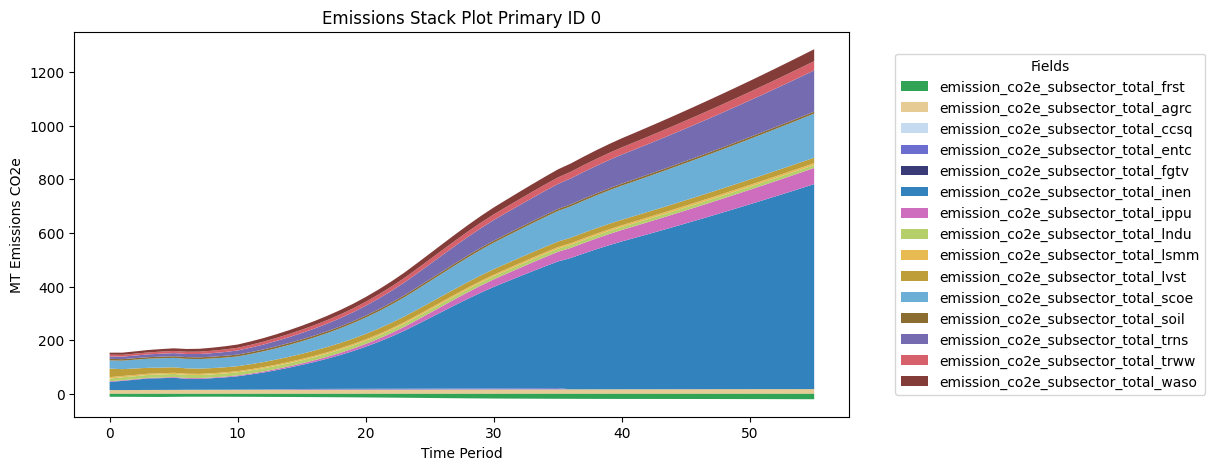

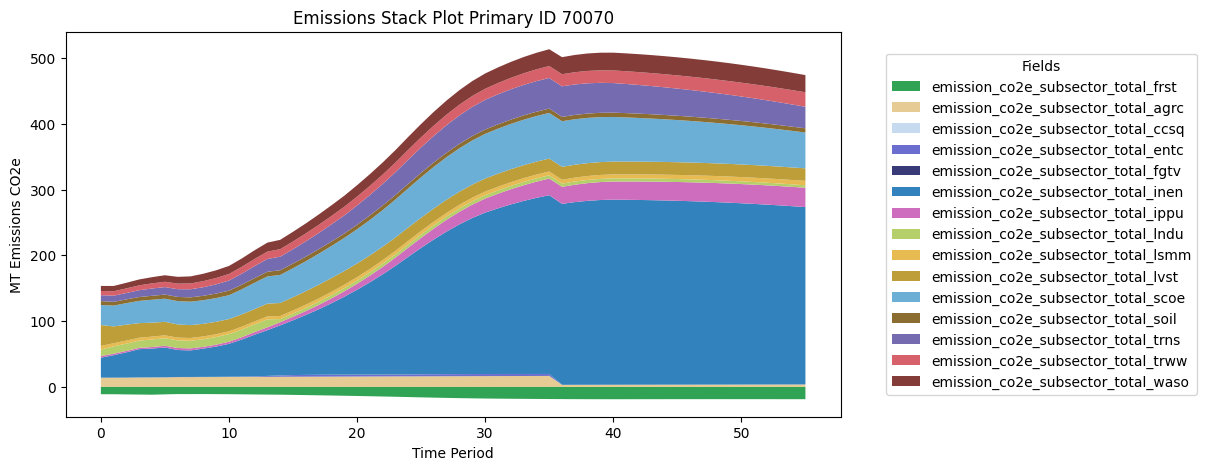

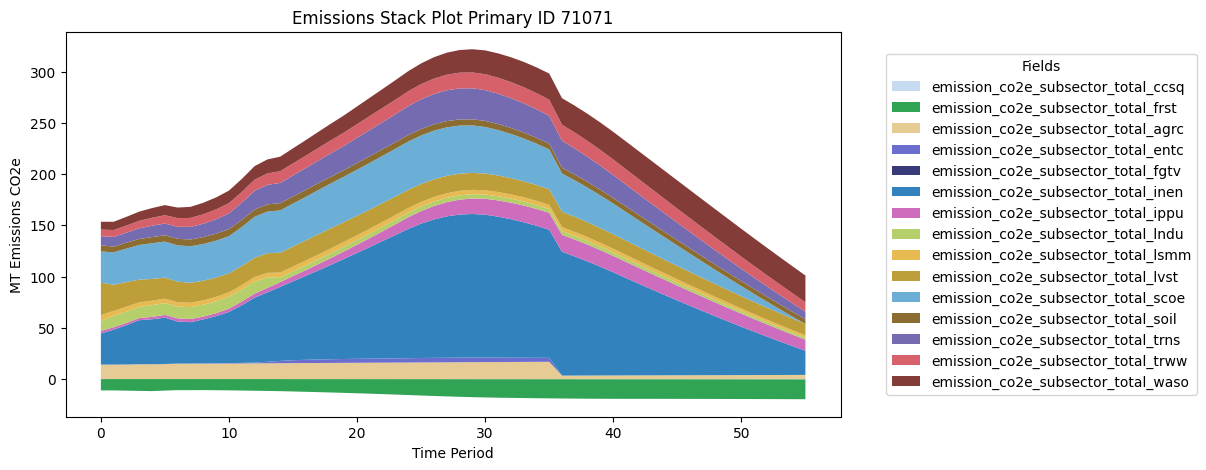

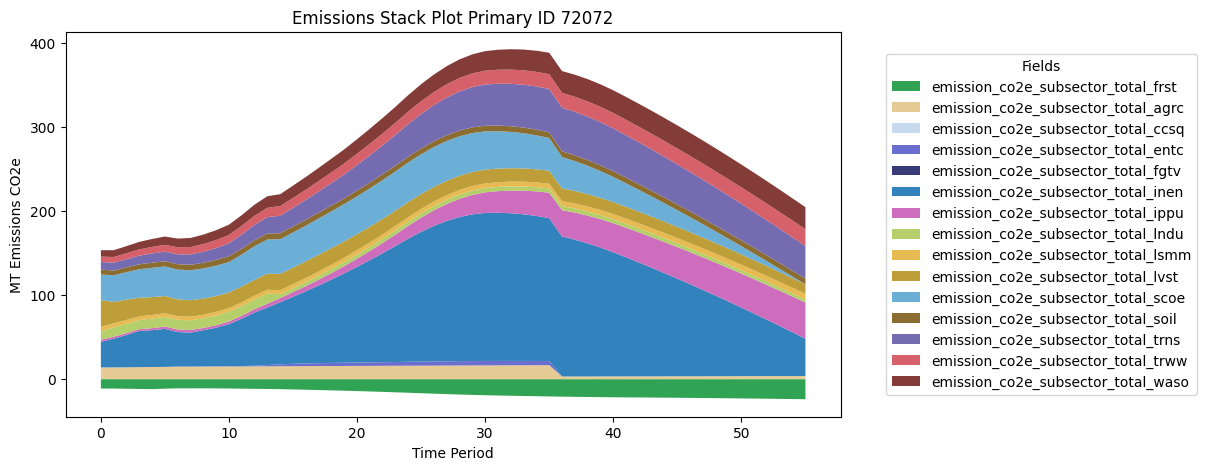

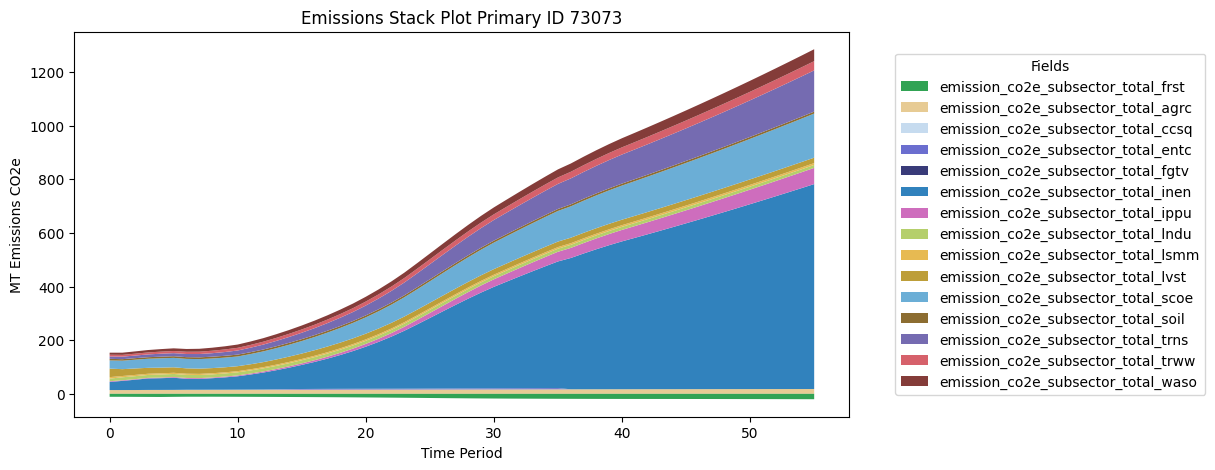

In [118]:
# Plot the emissions stack for the primary_id 0 (which is the baseline)

for single_id in run_primary_ids:

    plot_field_stack(
        df_out,
        subsector_emission_fields,
        dict_format,
        primary_id=single_id,
        title=f"Emissions Stack Plot Primary ID {single_id}"
    )

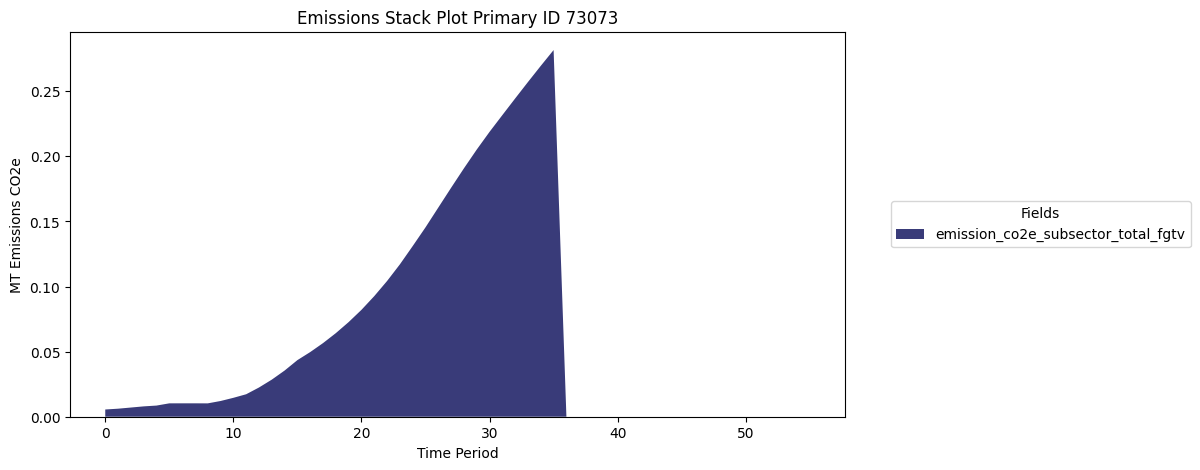

In [119]:
plot_field_stack(
        df_out,
        'emission_co2e_subsector_total_fgtv',
        dict_format,
        primary_id=single_id,
        title=f"Emissions Stack Plot Primary ID {single_id}"
    )

In [120]:
df_out['emission_co2e_co2_lndu_conversion_forests_secondary_to_croplands'] = 0

In [121]:
# --- Define fields  ---
fields_str = (
   "emission_co2e_co2_lndu_conversion_forests_mangroves_to_croplands:"
   "emission_co2e_co2_lndu_conversion_forests_mangroves_to_forests_mangroves:"
   "emission_co2e_co2_lndu_conversion_forests_mangroves_to_forests_primary:"
   "emission_co2e_co2_lndu_conversion_forests_mangroves_to_forests_secondary:"
   "emission_co2e_co2_lndu_conversion_forests_mangroves_to_grasslands:"
   "emission_co2e_co2_lndu_conversion_forests_mangroves_to_other:"
   "emission_co2e_co2_lndu_conversion_forests_mangroves_to_settlements:"
   "emission_co2e_co2_lndu_conversion_forests_mangroves_to_wetlands:"
   "emission_co2e_co2_lndu_conversion_forests_primary_to_croplands:"
   "emission_co2e_co2_lndu_conversion_forests_primary_to_forests_mangroves:"
   "emission_co2e_co2_lndu_conversion_forests_primary_to_forests_primary:"
   "emission_co2e_co2_lndu_conversion_forests_primary_to_forests_secondary:"
   "emission_co2e_co2_lndu_conversion_forests_primary_to_grasslands:"
   "emission_co2e_co2_lndu_conversion_forests_primary_to_other:"
   "emission_co2e_co2_lndu_conversion_forests_primary_to_settlements:"
   "emission_co2e_co2_lndu_conversion_forests_primary_to_wetlands:"
   "emission_co2e_co2_lndu_conversion_forests_secondary_to_croplands:"
   "emission_co2e_co2_lndu_conversion_forests_secondary_to_forests_mangroves:"
   "emission_co2e_co2_lndu_conversion_forests_secondary_to_forests_primary:"
   "emission_co2e_co2_lndu_conversion_forests_secondary_to_forests_secondary:"
   "emission_co2e_co2_lndu_conversion_forests_secondary_to_grasslands:"
   "emission_co2e_co2_lndu_conversion_forests_secondary_to_other:"
   "emission_co2e_co2_lndu_conversion_forests_secondary_to_settlements:"
   "emission_co2e_co2_lndu_conversion_forests_secondary_to_wetlands:"
   "emission_co2e_ch4_lndu_wetlands"
)
subsector_emission_fields = fields_str.split(":")
subsector_emission_fields

['emission_co2e_co2_lndu_conversion_forests_mangroves_to_croplands',
 'emission_co2e_co2_lndu_conversion_forests_mangroves_to_forests_mangroves',
 'emission_co2e_co2_lndu_conversion_forests_mangroves_to_forests_primary',
 'emission_co2e_co2_lndu_conversion_forests_mangroves_to_forests_secondary',
 'emission_co2e_co2_lndu_conversion_forests_mangroves_to_grasslands',
 'emission_co2e_co2_lndu_conversion_forests_mangroves_to_other',
 'emission_co2e_co2_lndu_conversion_forests_mangroves_to_settlements',
 'emission_co2e_co2_lndu_conversion_forests_mangroves_to_wetlands',
 'emission_co2e_co2_lndu_conversion_forests_primary_to_croplands',
 'emission_co2e_co2_lndu_conversion_forests_primary_to_forests_mangroves',
 'emission_co2e_co2_lndu_conversion_forests_primary_to_forests_primary',
 'emission_co2e_co2_lndu_conversion_forests_primary_to_forests_secondary',
 'emission_co2e_co2_lndu_conversion_forests_primary_to_grasslands',
 'emission_co2e_co2_lndu_conversion_forests_primary_to_other',
 'emiss

In [122]:
from statsmodels.tsa.filters.hp_filter import hpfilter

def hpfilter_df(df, cols, by="primary_id", x="time_period", lamb=100):
    df = df.sort_values([by, x]).copy()

    def _apply_hp(g):
        g = g.copy()
        for col in cols:
            cycle, trend = hpfilter(g[col], lamb=lamb)
            g[col] = trend.clip(lower=0)  # keep only the trend, no negatives
        return g

    return df.groupby(by, group_keys=False).apply(_apply_hp)

# Example: higher lambda → smoother trend
df_hp = hpfilter_df(
    df_out,
    subsector_emission_fields,
    by="primary_id",
    x="time_period",
    lamb=100  # try 100, 400, 1600 for different smoothness
)

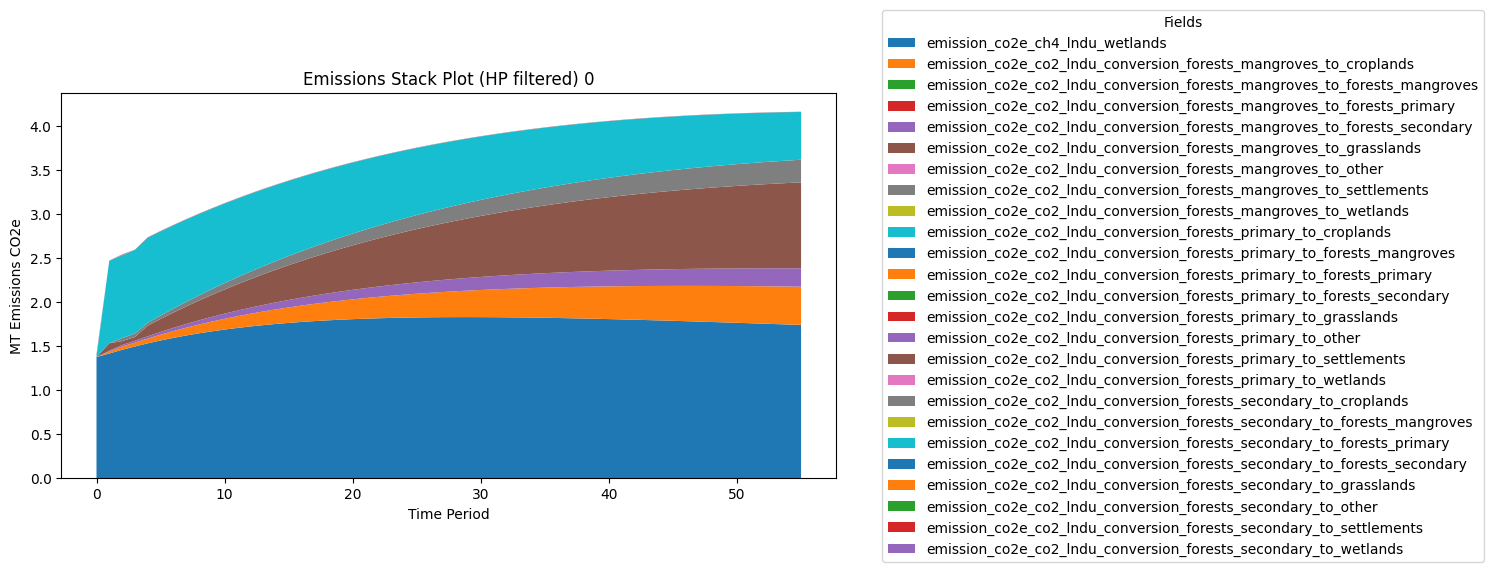

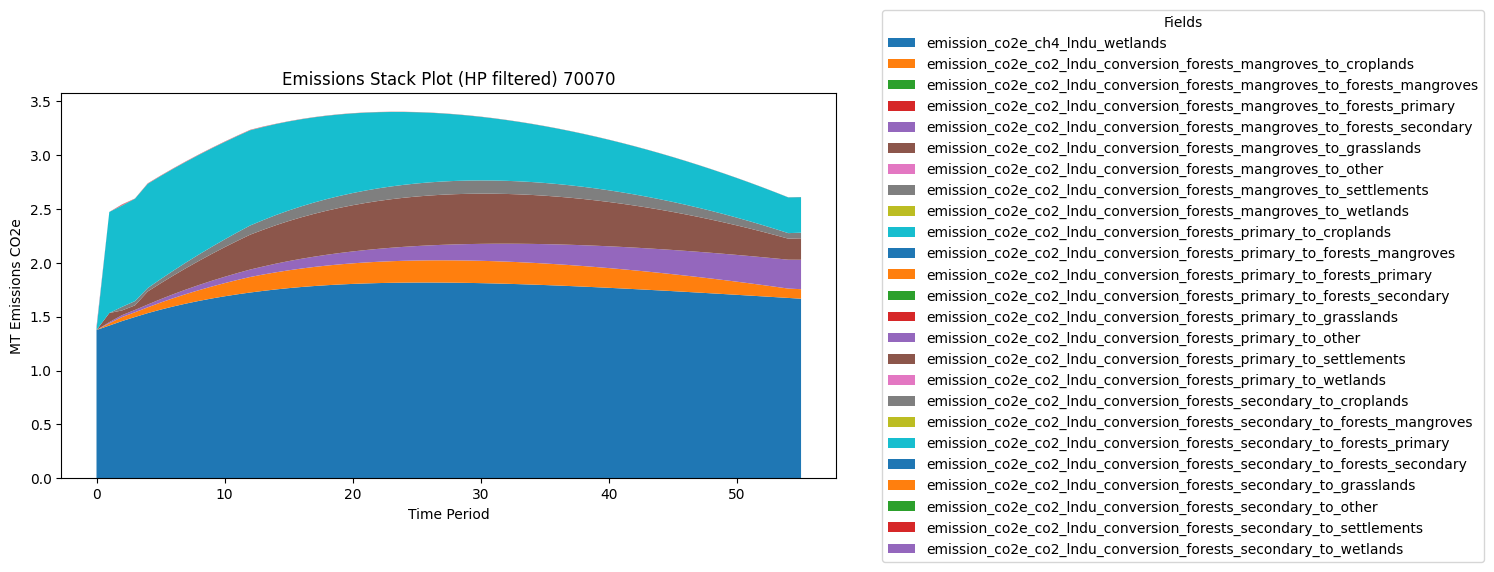

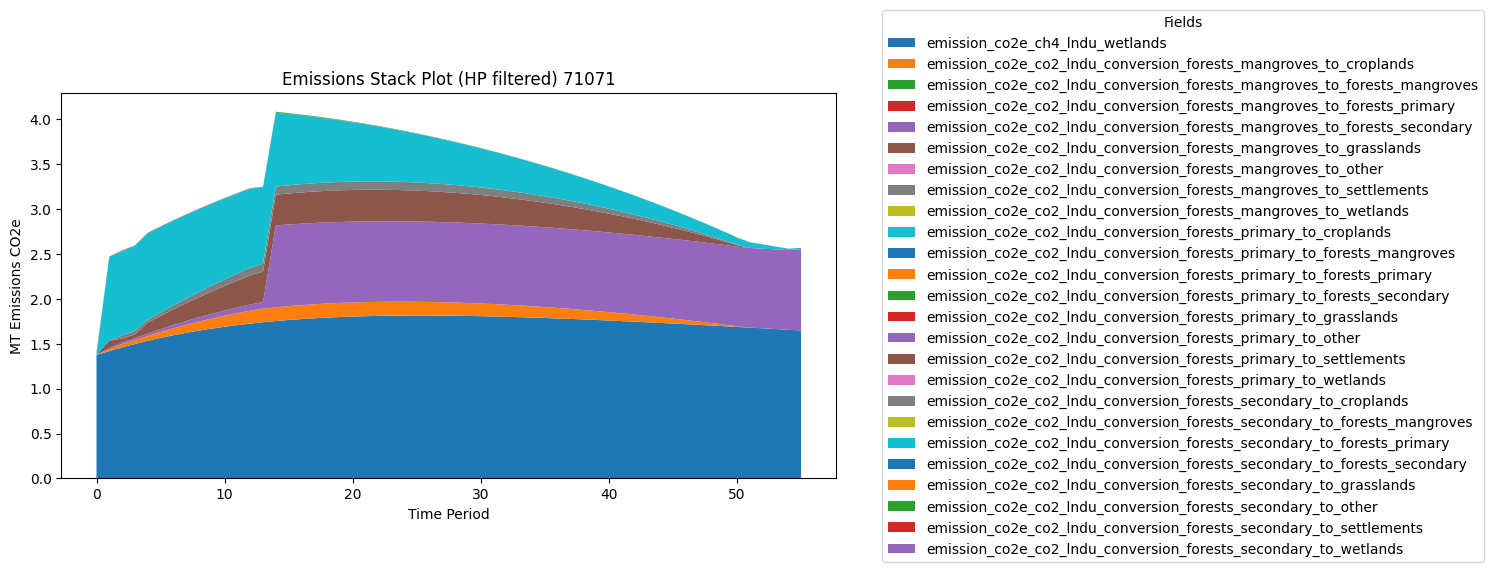

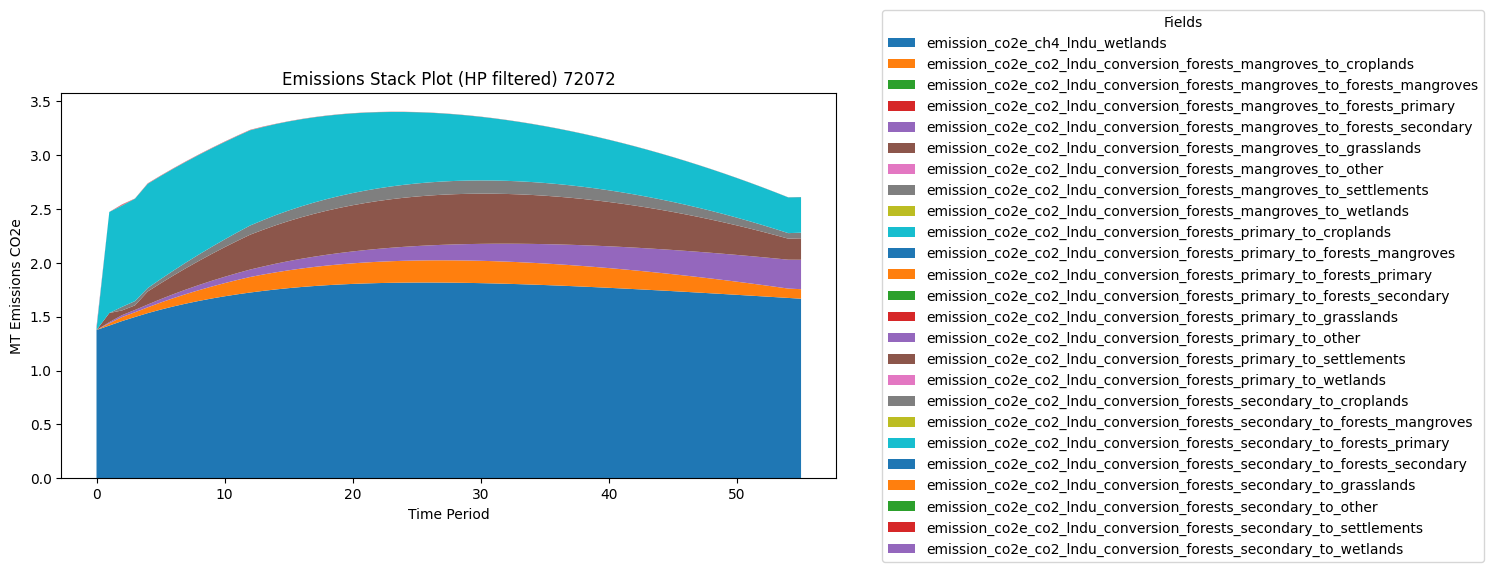

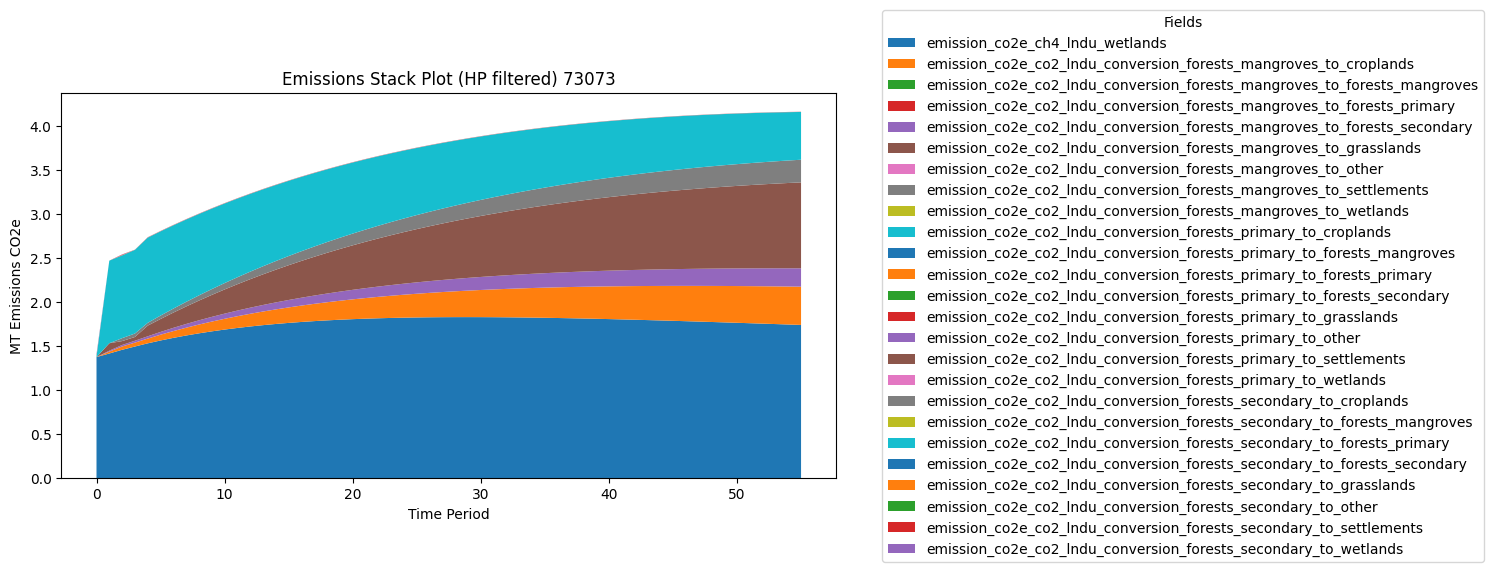

In [123]:
# Plot the emissions stack for the primary_id 0 (which is the baseline)

for single_id in run_primary_ids:

    plot_field_stack(
        df_out,
        subsector_emission_fields,
        dict_format,
        primary_id=single_id,
        title=f"Emissions Stack Plot (HP filtered) {single_id}" 
    )

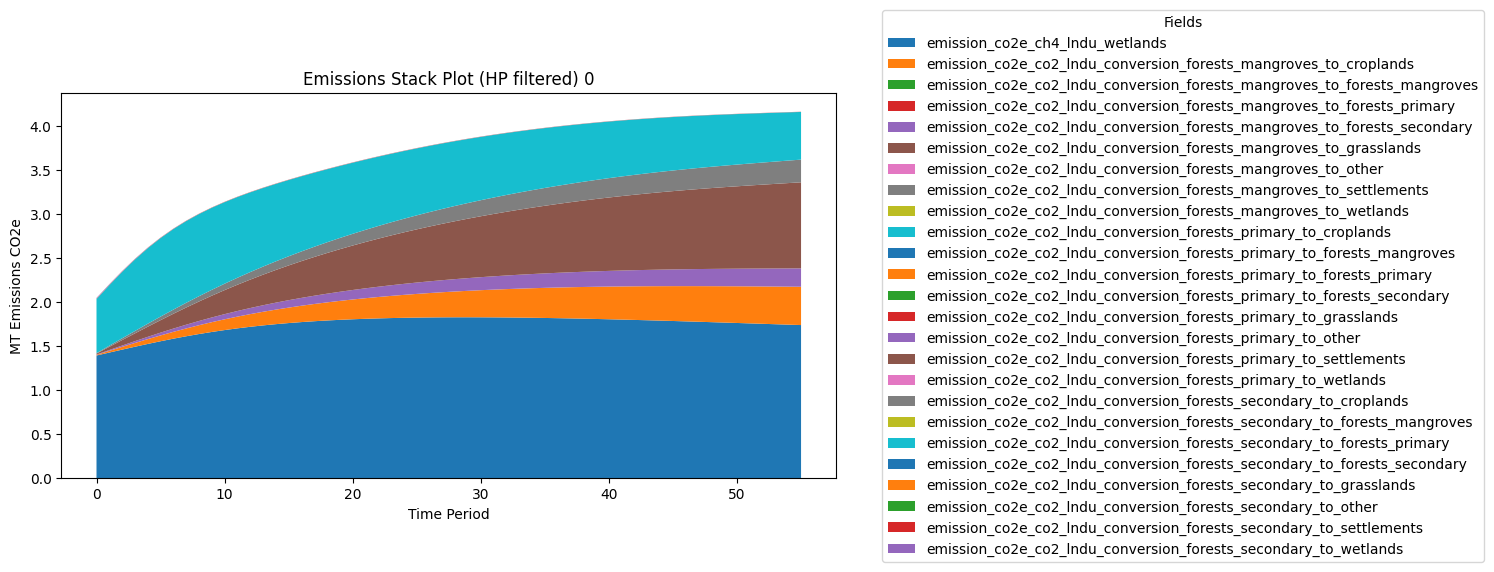

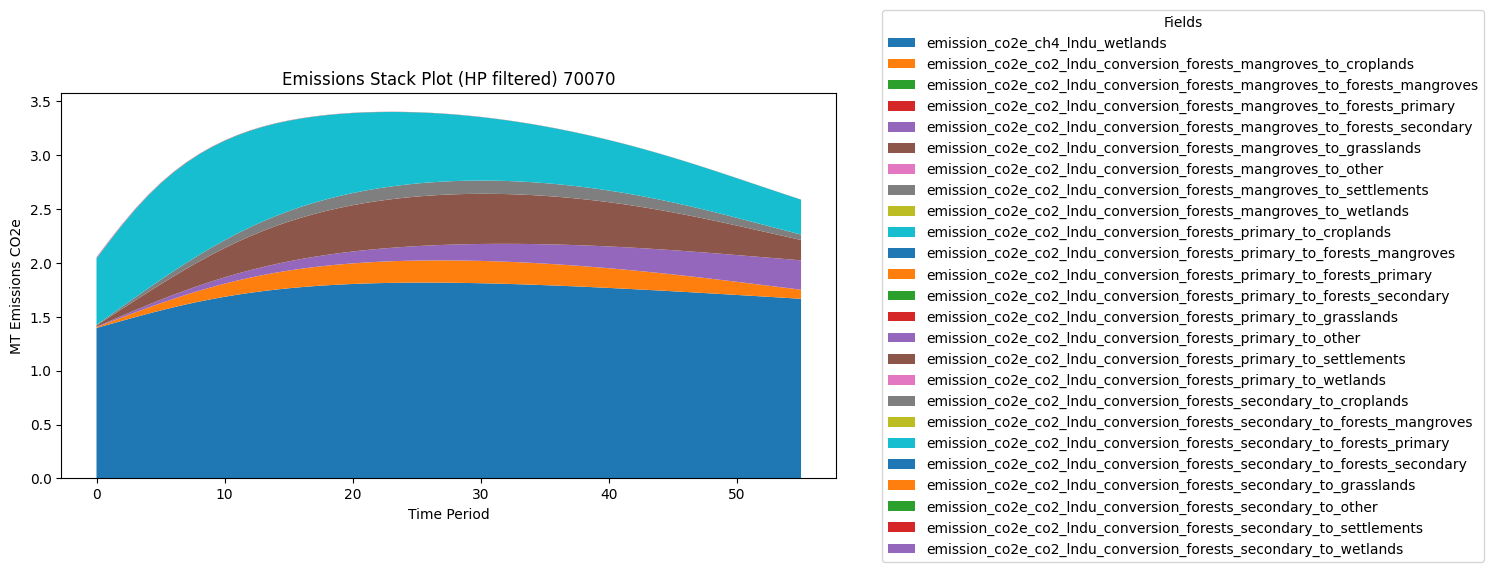

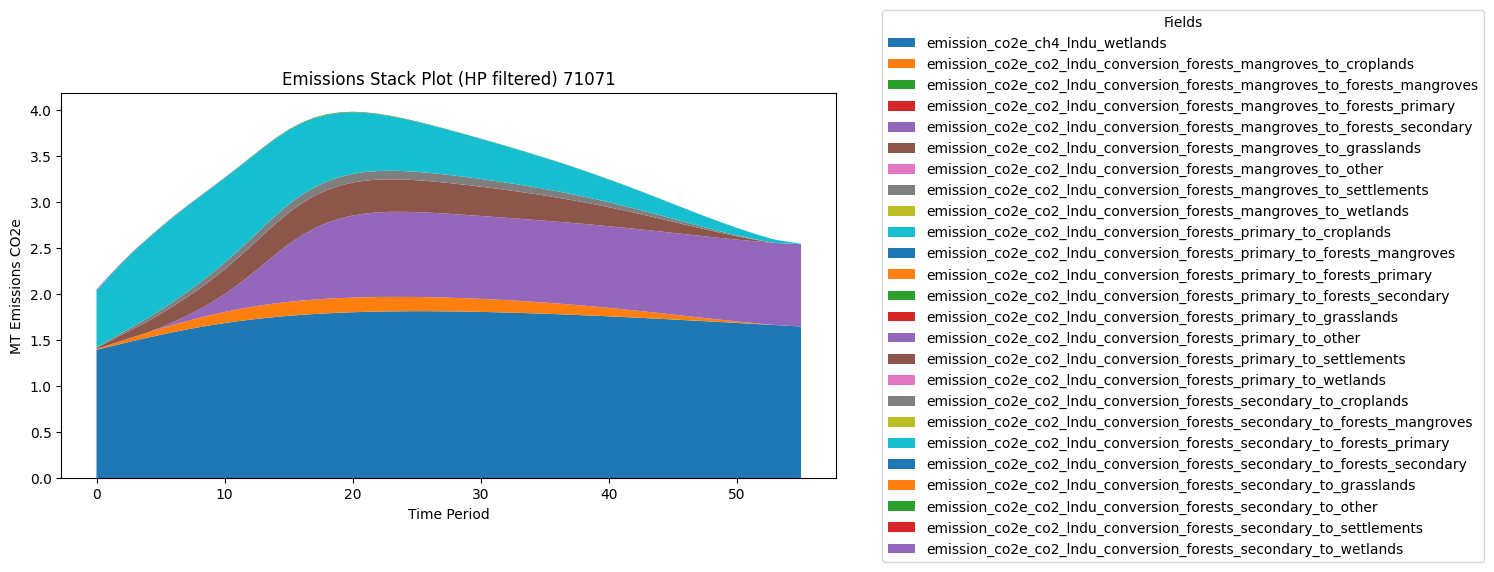

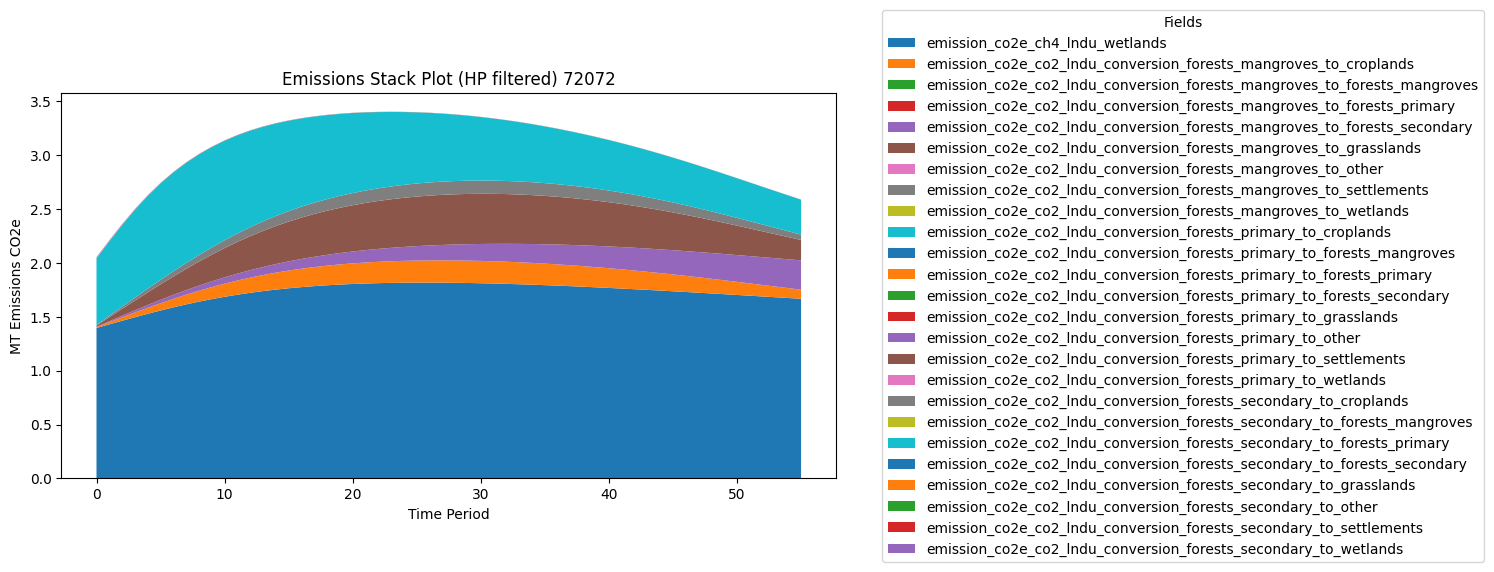

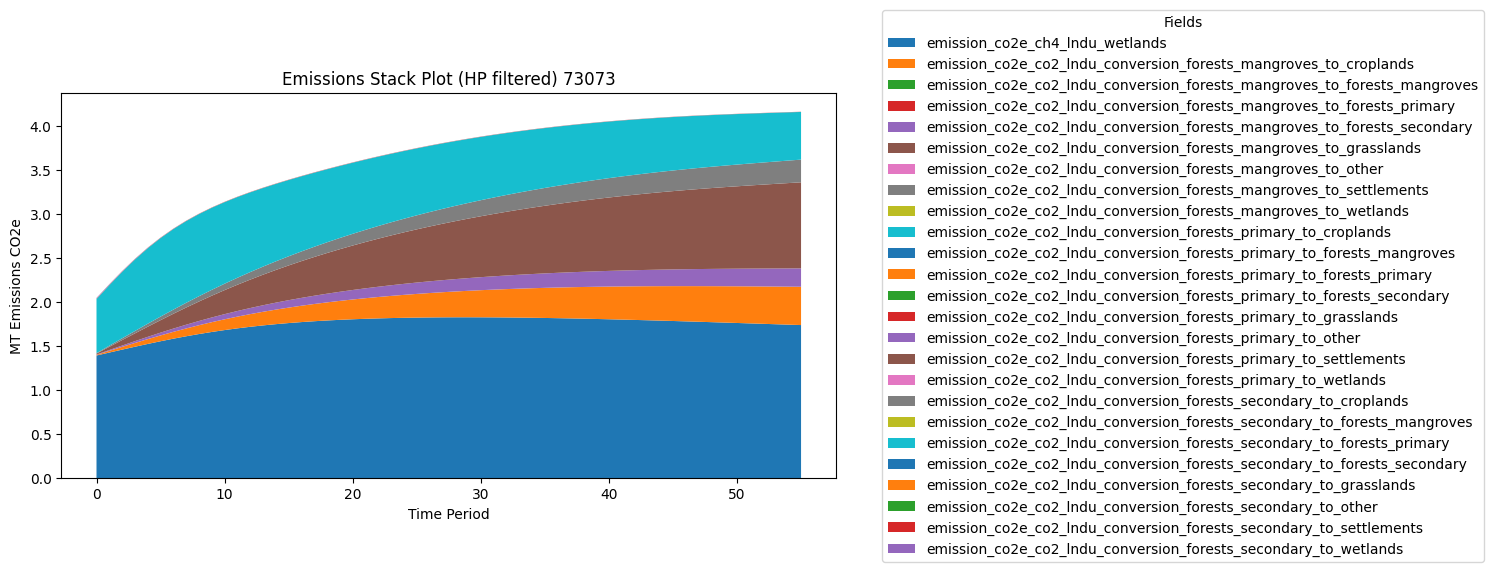

In [125]:
# Plot the emissions stack for the primary_id 0 (which is the baseline)

for single_id in run_primary_ids:

    plot_field_stack(
        df_hp,
        subsector_emission_fields,
        dict_format,
        primary_id=single_id,
        title=f"Emissions Stack Plot (HP filtered) {single_id}" 
    )

In [126]:
df_out[subsector_emission_fields] = df_hp[subsector_emission_fields]

In [127]:
# --- Define fields  ---
fields_str = (
   'emission_co2e_n2o_fgtv_fuel_coal:'
   'emission_co2e_n2o_fgtv_fuel_natural_gas:'
   'emission_co2e_n2o_fgtv_fuel_oil:'
   'emission_co2e_n2o_entc_fuel_mining_and_extraction_me_coal:'
   'emission_co2e_n2o_entc_fuel_mining_and_extraction_me_crude:'
   'emission_co2e_n2o_entc_fuel_mining_and_extraction_me_natural_gas:'
   'emission_co2e_n2o_entc_processing_and_refinement_fp_ammonia_production:'
   'emission_co2e_n2o_entc_processing_and_refinement_fp_hydrogen_electrolysis:'
   'emission_co2e_n2o_entc_processing_and_refinement_fp_hydrogen_gasification:'
   'emission_co2e_n2o_entc_processing_and_refinement_fp_hydrogen_reformation:'
   'emission_co2e_n2o_entc_processing_and_refinement_fp_hydrogen_reformation_ccs:'
   'emission_co2e_n2o_entc_processing_and_refinement_fp_natural_gas:'
   'emission_co2e_n2o_entc_processing_and_refinement_fp_petroleum_refinement'
)
subsector_emission_fields = fields_str.split(":")
subsector_emission_fields

['emission_co2e_n2o_fgtv_fuel_coal',
 'emission_co2e_n2o_fgtv_fuel_natural_gas',
 'emission_co2e_n2o_fgtv_fuel_oil',
 'emission_co2e_n2o_entc_fuel_mining_and_extraction_me_coal',
 'emission_co2e_n2o_entc_fuel_mining_and_extraction_me_crude',
 'emission_co2e_n2o_entc_fuel_mining_and_extraction_me_natural_gas',
 'emission_co2e_n2o_entc_processing_and_refinement_fp_ammonia_production',
 'emission_co2e_n2o_entc_processing_and_refinement_fp_hydrogen_electrolysis',
 'emission_co2e_n2o_entc_processing_and_refinement_fp_hydrogen_gasification',
 'emission_co2e_n2o_entc_processing_and_refinement_fp_hydrogen_reformation',
 'emission_co2e_n2o_entc_processing_and_refinement_fp_hydrogen_reformation_ccs',
 'emission_co2e_n2o_entc_processing_and_refinement_fp_natural_gas',
 'emission_co2e_n2o_entc_processing_and_refinement_fp_petroleum_refinement']

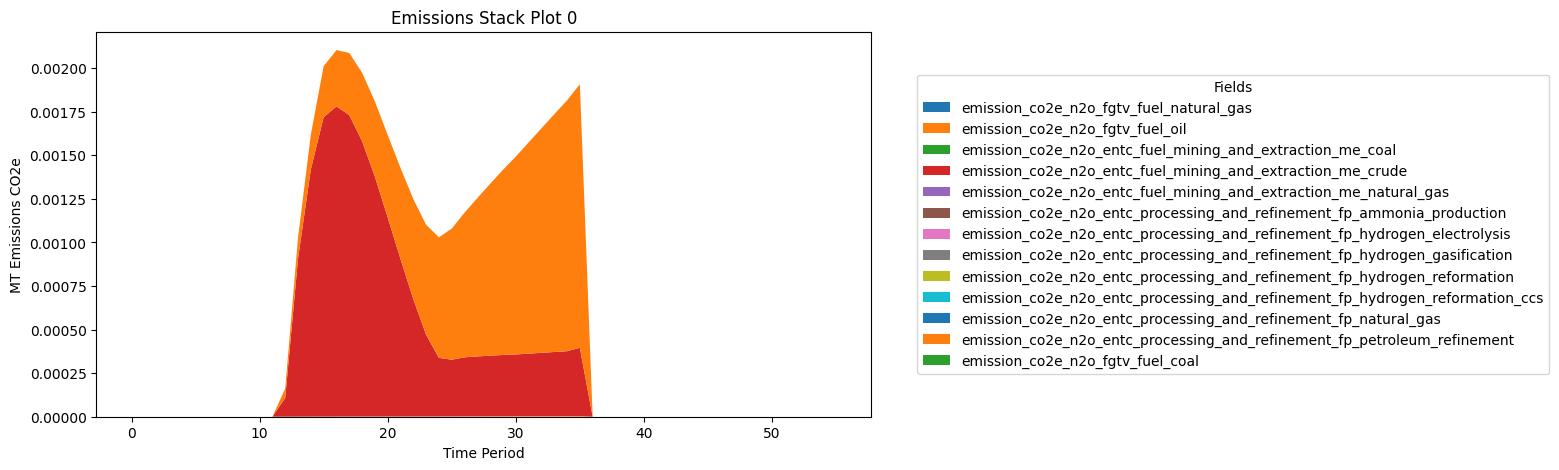

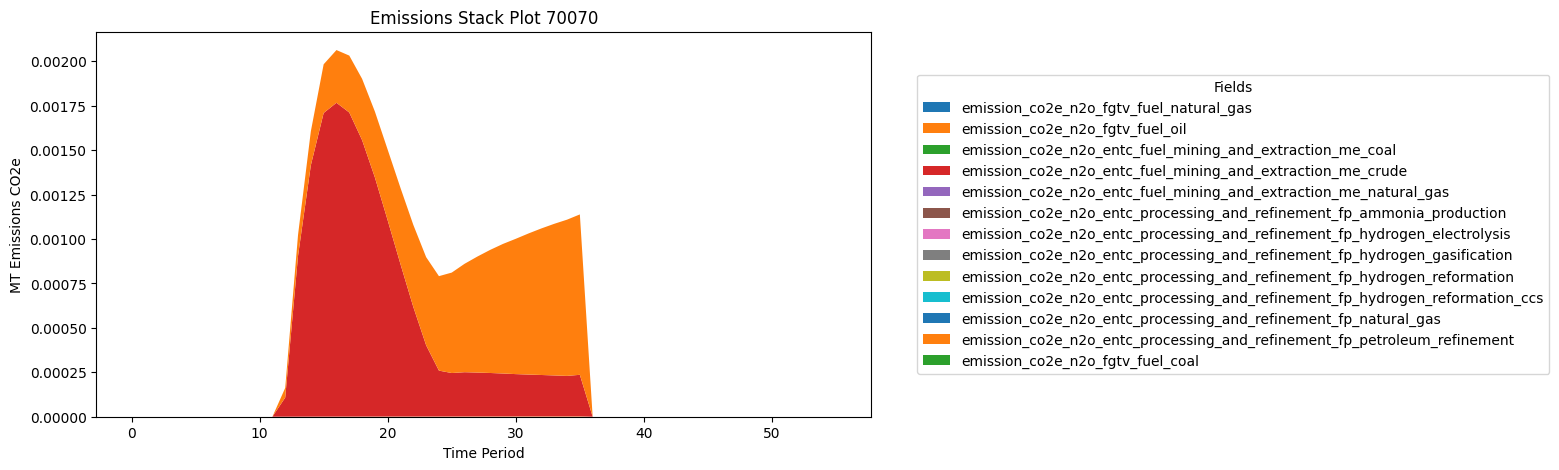

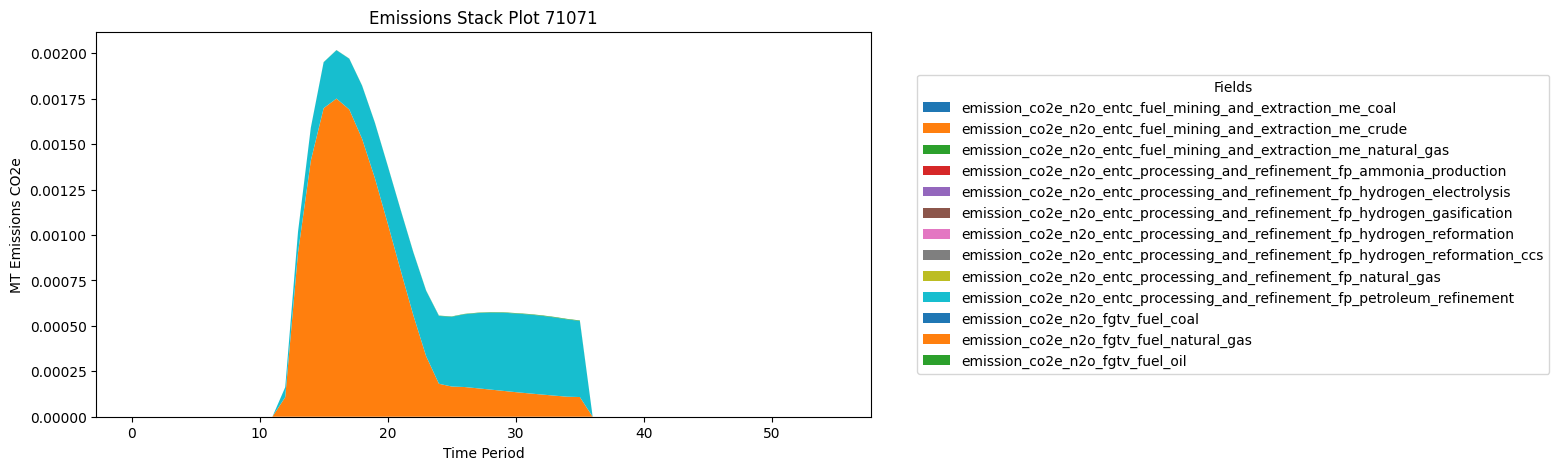

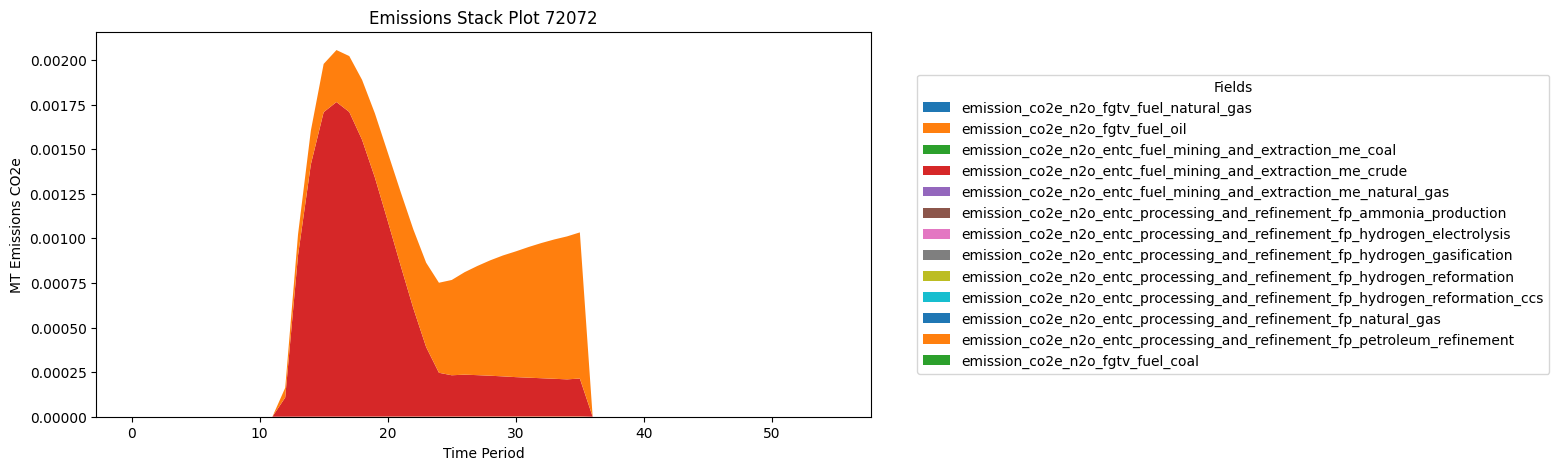

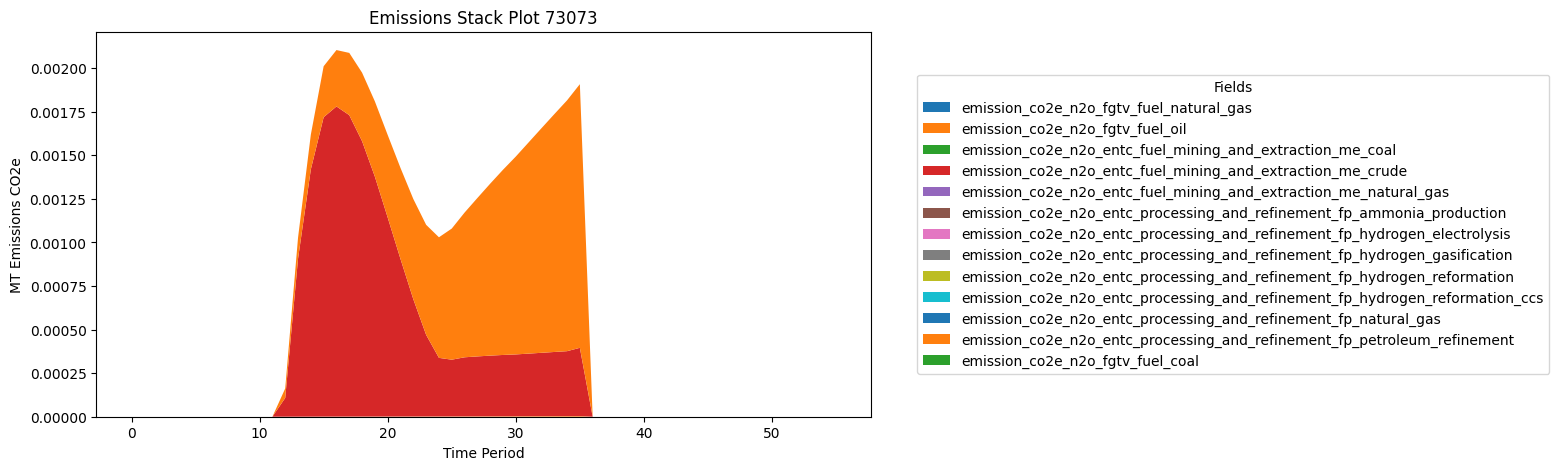

In [128]:
# Plot the emissions stack for the primary_id 0 (which is the baseline)
for single_id in run_primary_ids:

    plot_field_stack(
        df_out,
        subsector_emission_fields,
        dict_format,
        primary_id=single_id,
        title=f"Emissions Stack Plot {single_id}" 
    )

In [129]:
# Define cut year where you want the flat projection to start
cut_year = 1

for pid in run_primary_ids:
    print(pid)
    # Mask for the future part
    mask_future = (df_out["primary_id"] == pid) & (df_out["time_period"] >= cut_year)

    # Get the last historical values before the cut
    last_vals = df_out.loc[
        (df_out["primary_id"] == pid) & (df_out["time_period"] < cut_year),
        subsector_emission_fields
    ].iloc[-1]

    # Assign the last values to all future rows
    df_out.loc[mask_future, subsector_emission_fields] = last_vals.values

0
70070
71071
72072
73073


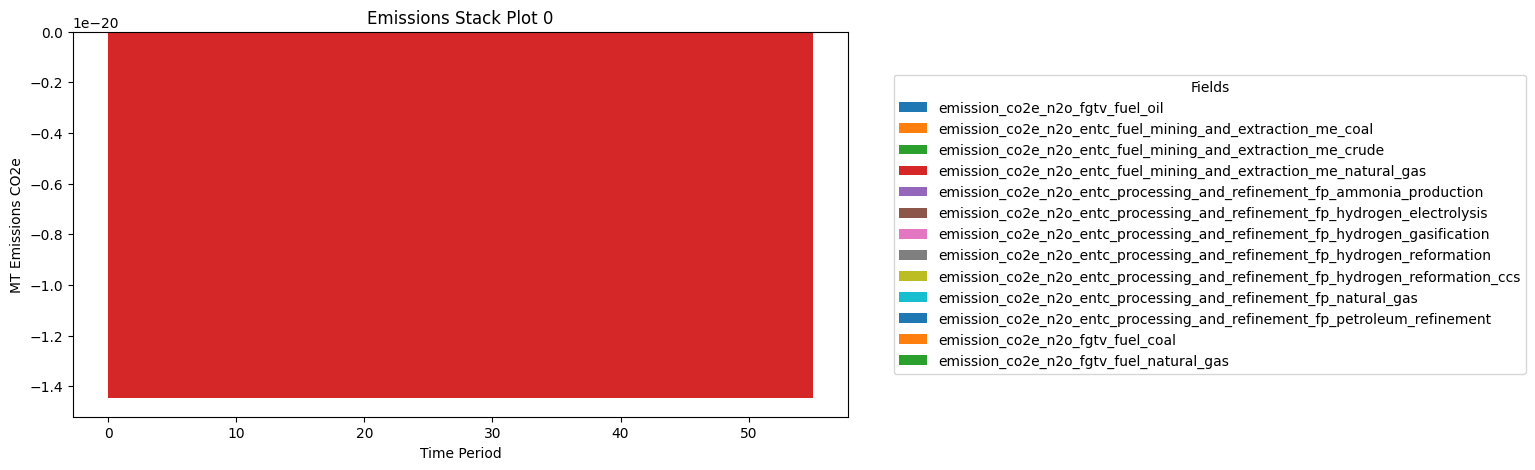

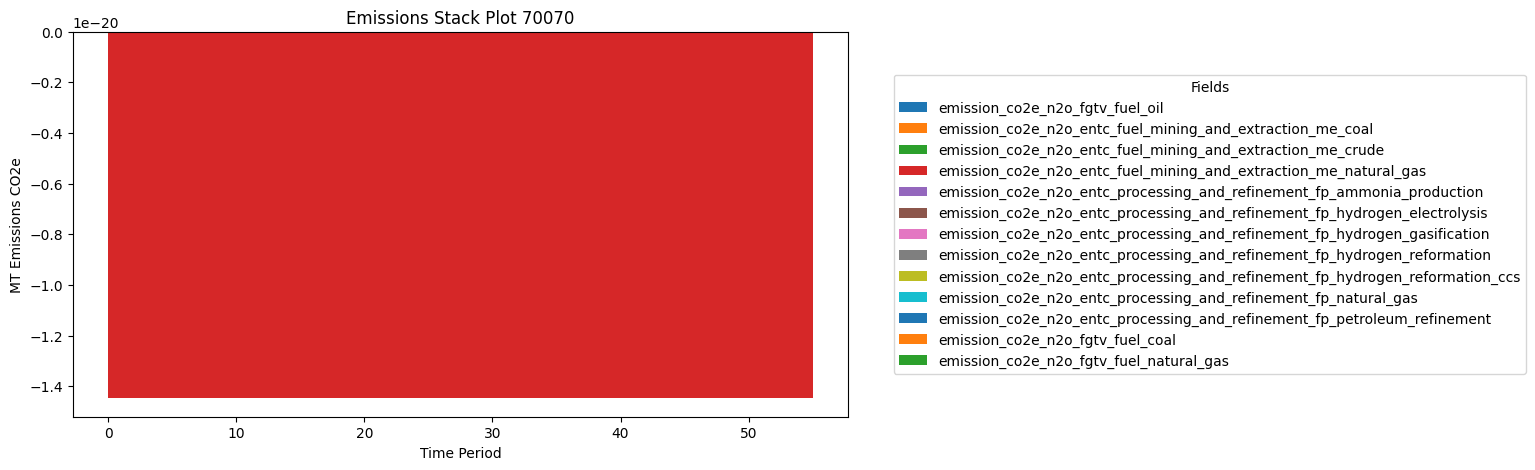

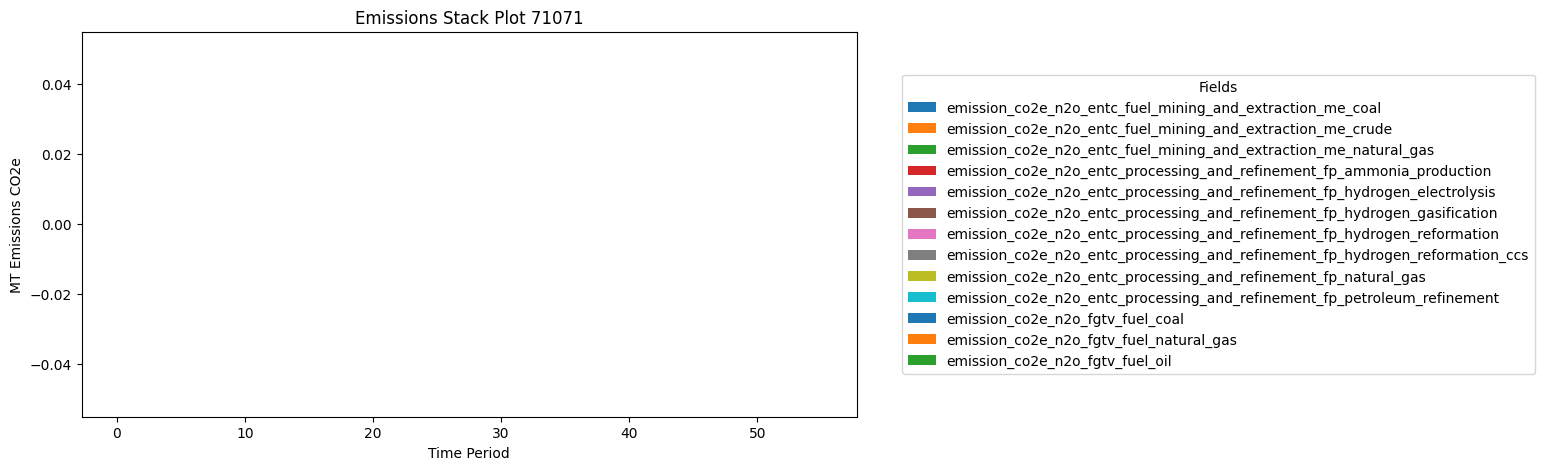

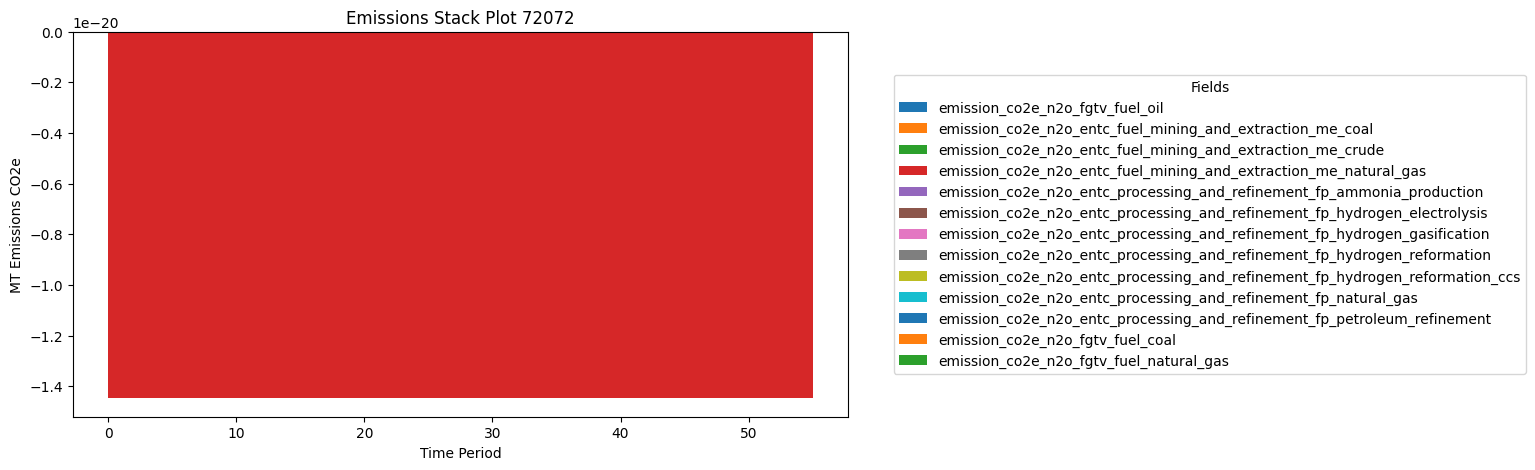

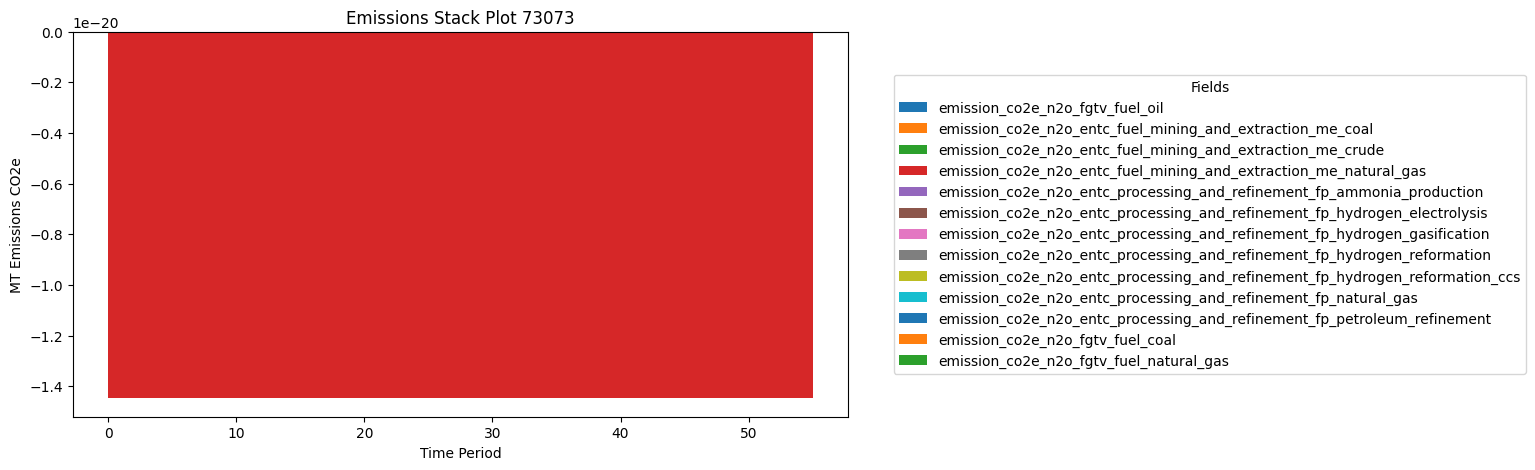

In [130]:
# Plot the emissions stack for the primary_id 0 (which is the baseline)
for single_id in run_primary_ids:

    plot_field_stack(
        df_out,
        subsector_emission_fields,
        dict_format,
        primary_id=single_id,
        title=f"Emissions Stack Plot {single_id}" 
    )

# Export Wide File (Last Mandatory Step)

In [131]:
# Export Wide File (Last Mandatory Step)
all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)



# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_pkg, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)
# Getting the directory where the outputs are stored
ssp.file_struct.dir_out
RUN_ID_OUTPUT_DIR_PATH = os.path.join(
    RUN_OUTPUT_DIR_PATH, 
    ssp.id_fs_safe
)

os.makedirs(RUN_ID_OUTPUT_DIR_PATH, exist_ok=True)

df_primary.to_csv(
    os.path.join(RUN_ID_OUTPUT_DIR_PATH, "ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(

    
    os.path.join(RUN_ID_OUTPUT_DIR_PATH, f"{ssp.id_fs_safe}.csv"),
    index = None,
    encoding = "UTF-8"
)

for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(RUN_ID_OUTPUT_DIR_PATH, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        logger.warning(f"Warning: Table {tab} returned None.")
